# Desafio - Ensembles
# Previsão de Churn de Clientes

### Proposto por Allan Dieguez (LuizaLabs)
### Resolução por Daniel Jullien

## Índice
* [Introdução](#introduction)
* [Metodologia](#methodology)
* [Aquisição de Dados](#data)
* [Análise Exploratória](#eda)
* [Pré-Processamento](#preprocessing)
* [Feature Engineering](#featureengineering)
* [Análise Exploratória Final](#finaleda)
* [Modelagem](#modelagem)
* [Ensembles](#ensembles)
* [Feature Importance](#importance)
* [Conclusão](#conclusao)

## 1. Introdução <a name="introduction"></a>

O desafio de prever se um cliente irá sair da Base de Clientes Ativos (também conhecido como churn) não é um problema exclusivo do varejo, sendo uma área de estudos constante da maioria das indústrias e empresas de serviços que dependem da retenção.

Esse é um exemplo do tipo de problema que um cientista do Chapter de Ciência de Dados do Luizalabs entra de cabeça e cujas soluções servem para alavancar várias frentes de trabalho. A solução em si já traz muito valor, se tiver alto índice de acertos pode ser usada para elencar automaticamente clientes com alto risco de churn para uma promoção agressiva com o objetivo retê-lo na base.

Também há muito valor nos insights e na validação de hipóteses que acontece durante o processo de análise do problema e das soluções. Pode-se verificar através de experimentação que, por exemplo, um cliente que compra exclusivamente em datas especiais ou eventos promocionais tem uma chance menor de ser um churn do que um que compra grandes volumes do mesmo produto.


OBJETIVO
Nesse desafio, construído em uma parceria da Tera e o Luizalabs, o objetivo principal será construir algumas soluções baseadas em machine learning para prever se um dado cliente do e-commerce do Magalu continuará comprando na plataforma em 2020 usando algumas características próprias do cliente e seu histórico de compras no ano anterior. No final, algumas dessas soluções devem ser combinadas em um ensemble para criar uma solução única com o objetivo de alavancar ainda mais os resultados.

Para que o objetivo principal seja cumprido, será necessário construir uma forma de visualização das soluções criadas e a comparação com o modelo baseline e com o modelo de ensemble criados no processo. O formato sugerido é um tabela de resultados contendo as métricas de sucesso de cada modelo criado.

O objetivo secundário é o levantamento de hipóteses e insights que surgirem durante as experimentações. É interessante fazer isso desde o início como parte da análise exploratória, documentando qualquer indício de informação nova sobre o problema. Também é uma boa prática avaliar os modelos treinados, seja através da exploração de seus parâmetros (por exemplo, os pesos de um modelo linear) ou usando técnicas avançadas como o SHAP.

(https://www.kaggle.com/dansbecker/shap-values), buscando relacionar como as features influenciam as respostas do modelo.

A forma mais simples de cumprir o objetivo secundário é a documentação das etapas de análise e exploração de forma resumida em um relatório que compila as principais hipóteses e insights. Esse relatório pode ser um documento de texto na forma de um diário de bordo ou mesmo uma seção do próprio notebook em que a solução foi desenvolvida.

PONTUAÇÃO
O desafio também possui um dataset de pontuação, contendo dados de clientes que não estão nem nas bases de treino nem nas de teste. Para esses clientes não foram disponibilizadas as respostas (targets), sendo portanto impossível verificar durante o desenvolvimento da solução se o modelo está acertando ou não.

O objetivo desse dataset é permitir, de forma justa, que os alunos possam comparar suas melhores soluções com as dos outros. Através desse link (https://docs.google.com/forms/d/e/1FAIpQLSe0oWpeUQQED_VPvZ04gP-yBQYbNxVnij4J9tyEwmvFtovNyg/viewform) é possível fazer o envio do arquivo de respostas do desafio. No fim do desafio, será mostrado o ranking dos envios dos alunos.



## Base de dados 

Todos os dados disponibilizados para esse desafio estão em arquivos no formato csv, podendo ser baixados para serem trabalhados localmente ou em um notebook do Google Colab como este aqui.

Os dados sensíveis ou privados de clientes e produtos estão todos anonimizados, respeitando a privacidade dos mesmos e evitando o vazamento de informações estratégicas da empresa.

Esses dados anonimizados incluem informações de IDs de entidades (clientes, vendas e produtos), os estados de origem do cliente e de destino do produto e a estrutura mercadológica dos produtos (nomes de categorias e subcategorias às quais pertencem), assim como sua descrição (nome do produto incluso).

Nessa seção serão descritas as tabelas e suas colunas do desafio. Os links para os arquivos e a descrição de cada um está nas seções a seguir. Algumas definições de código e extrações já serão feitas nesse momento, para facilitar o uso dos dados no restante do _notebook_ e para facilitar a explicação de cada elemento.


Os dados de clientes estão contidos em **3 arquivos** _csv_ já separados em **treino**, **teste** e **desafio**. Isso foi feito previamente para que os três _datasets_ tivessem distribuições justas das **_features_ de interesse**, representando fielmente o domínio do problema.

- `client_id`: ID global único do cliente
- `birthdate`: data de nascimento do cliente
- `state`: estado onde o cliente mora
- `gender`: gênero declarado pelo cliente
- `is_churn`: variável dependente (_target_) que diz se o cliente será _churn_ ou não

As colunas da Tabela de Produtos são todas simbólicas, representando as diferentes categorias da **árvore de Estrutura Mercadológica** onde o produto está inserido. 

Os nomes das subcategorias herdam o nome da categoria pai, de forma que todas as subcategorias da coluna `category_lv2` que começam com "mk38:072" possuem como categoria pai a `category_lv1` de nome "mk38:072", que por sua vez é filho da `category_lv0` de nome "mk38".

Um exemplo da categorização:

- `category_lv0`: Categorias mais abrangentes dos produtos; e.g. "Eletrônicos" ou "Moda"
- `category_lv1`: Subcategorias; e.g. "Eletrônicos->Notebooks"
- `category_lv2`: Sub-subcategorias; e.g. "Eletrônicos->Notebooks->UltraFinos"

e assim por diante.

A coluna `product_id` é a referência global de produtos, que pode ser combinada por _merge_ com a tabela de vendas.

### Histórico de Vendas

Os **dados do histórico de todas as vendas** de 2019 para **todos os clientes** nos 3 datasets de cliente que compraram qualquer produto - todos contidos no dataset de produtos.

As colunas dessa tabela estão descritas a seguir.

As colunas de ID de entidade são:
- `order_id`: identificador da venda; pode estar repetida em outras linhas, pois **cada linha corresponde à compra de um produto por um cliente**, que pode ter comprado outros produtos no mesmo evento.
- `client_id`: identificador do cliente que realizou a compra
- `datetime`: data e hora da compra
- `units`: quantidade de unidades do produto que foram comprados nesse evento de compra
- `price`: preço unitário do produto comprado
- `payment_method`: forma de pagamento (crétido, débito, _voucher_, etc) da compra
- `installments`: número de parcelas do pagamento; se estiver vazio, pode-se considerar que não se aplica
- `delivery_days`: prazo de entrega do produto
- `delivery_state`: estado onde ocorreu a entrega do produto; corresponde exatamente ao estado nas tabelas de cliente
- `device`: meio por onde  o cliente comprou; e.g. site, aplicativo do celular, terminal de compras
- `source`: canal de _marketing_ que gerou o _lead_ e ocasionou ao cliente comprar; por exemplo, pode ser um link em uma página parceira onde o cliente viu uma promoção

## 2. Metodologia<a name="methodology"></a>

As etapas a seguir são a sugestão de passos mínima para a solução do problema de forma estruturada. Em alguns passos serão dadas algumas sugestões de código para o melhor aproveitamento do esforço de exploração e construção de solução.

A idéia não é engessar a abordagem, mas apenas criar uma trilha minimamente estruturada para que seja fácil rastrear os passos da solução. O passo inicial será sempre a **análise exploratória** para entender os dados brutos, seguido por um ajuste dos elementos do dataset baseada nas descobertas em uma etapa de **limpeza e pré-processamento** dos dados.

## 3. Aquisição de Dados<a name="data"></a>

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para tratamento de dados em cpu
import pandas as pd
import numpy as np

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# Bibliotecas processamento
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#from sklearn.preprocessing import Normalizer, LabelEncoder, OneHotEncoder
#from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import accuracy_score, recall_score,f1_score, roc_auc_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report

# Classifier Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Grid Search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Feature importance
from sklearn.inspection import permutation_importance
import shap

from mlxtend.plotting import plot_learning_curves


# Ensembles
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

In [5]:
clients_train = pd.read_csv('client.train.csv')
clients_test = pd.read_csv('client.test.csv')
clients_challenge = pd.read_csv('client.challenge.data.csv')
orders = pd.read_csv('orders.csv')
product = pd.read_csv('product.csv')

In [6]:
clients_train.head()

,client_id,birthdate,state,gender,is_churn
0,cx05072,1972-03-22,st25,cg2,False
1,cx03836,1966-08-14,st15,cg1,False
2,cx08472,1954-08-07,st15,cg1,False
3,cx12946,1955-11-16,st15,cg1,False
4,cx19045,1958-10-25,st15,cg2,False


In [7]:
clients_train.shape

(23292, 5)

In [8]:
clients_test.head()

,client_id,birthdate,state,gender,is_churn
0,cx06840,1982-12-03,st15,cg1,False
1,cx01931,1979-05-09,st15,cg1,False
2,cx35431,1965-05-09,st15,cg1,False
3,cx36233,1954-03-15,st15,cg2,False
4,cx13540,1965-06-19,st15,cg1,False


In [9]:
clients_test.shape

(7764, 5)

In [10]:
clients_challenge.head()

,client_id,birthdate,state,gender
0,cx12525,1932-04-19,st15,cg1
1,cx32280,1983-03-01,st15,cg1
2,cx00471,1964-08-30,st15,cg2
3,cx18876,1971-04-27,st15,cg2
4,cx38255,1958-01-26,st15,cg1


In [11]:
clients_challenge.shape

(7765, 4)

In [12]:
orders.head()

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.9,pm05,NaN,NaN,st07,dv9,sc08
1,ox070389,cx05072,px12305,2019-10-11 17:42:00,1.0,69.9,pm05,NaN,NaN,st07,dv9,sc08
2,ox061137,cx06840,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,NaN,NaN,st07,dv9,sc08
3,ox061137,cx06840,px05992,2019-01-19 13:09:00,3.0,35.9,pm05,NaN,NaN,st07,dv9,sc08
4,ox038612,cx06840,px10040,2019-04-18 14:36:00,1.0,39.0,pm05,NaN,NaN,st07,dv9,sc08


In [13]:
orders.shape

(168472, 12)

In [14]:
product.head()

,product_id,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,px01237,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:04846
1,px11510,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:01337
2,px03782,mk38,mk38:072,mk38:072:019,mk38:072:019:066,mk38:072:019:066:02321
3,px04092,mk38,mk38:072,mk38:072:019,mk38:072:019:054,mk38:072:019:054:06035
4,px07429,mk38,mk38:072,mk38:072:078,mk38:072:078:182,mk38:072:078:182:07218


In [15]:
product.shape

(12659, 6)

## 4. Análise Exploratória <a name="eda"></a>

Para a análise, criarei um novo dataframe, unindo os 3 anteriores, mas antes, uma análise rápida das colunas e missing values separadamente.

#### Clients

In [16]:
clients_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23292 entries, 0 to 23291
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  23292 non-null  object
 1   birthdate  23292 non-null  object
 2   state      23292 non-null  object
 3   gender     23292 non-null  object
 4   is_churn   23292 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 750.7+ KB


In [17]:
clients_train.isna().mean()

client_id    0.0
birthdate    0.0
state        0.0
gender       0.0
is_churn     0.0
dtype: float64

Não há missing values nos dados de cliente.

In [18]:
clients_train.describe(include='all')

,client_id,birthdate,state,gender,is_churn
count,23292,23292,23292,23292,23292
unique,23292,13046,27,2,2
top,cx04158,1990-01-01,st15,cg1,False
freq,1,58,8201,12879,19085


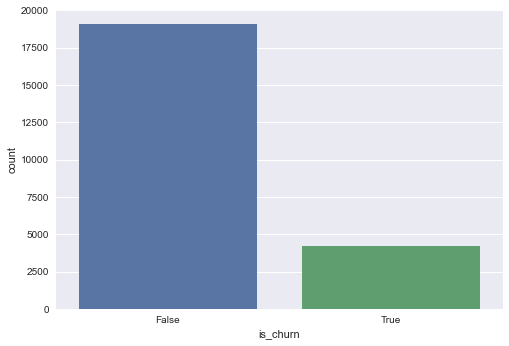

In [19]:
sns.countplot(data=clients_train, x='is_churn')
plt.show()

In [20]:
clients_train.value_counts('is_churn', normalize=True)

is_churn
False    0.81938
True     0.18062
dtype: float64

Dados desbalanceados, com uma proporção próxima a 80-20.

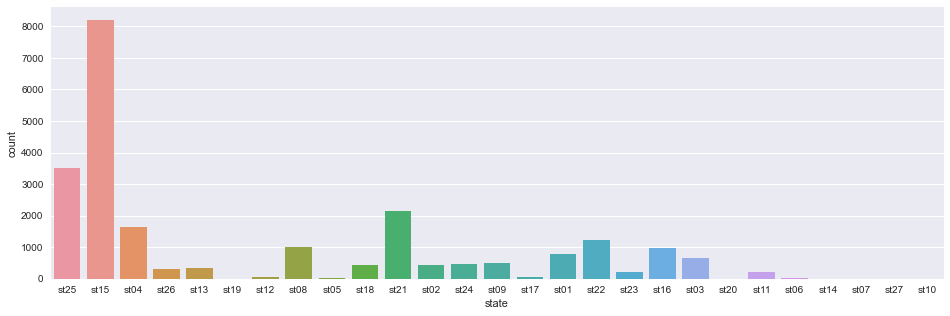

In [21]:
plt.figure(figsize=(16,5))
sns.countplot(data=clients_train, x='state')
plt.show()

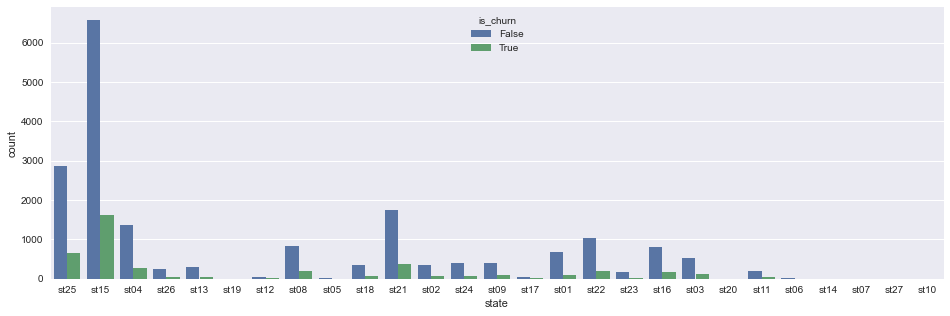

In [22]:
plt.figure(figsize=(16,5))
sns.countplot(data=clients_train, x='state', hue='is_churn')
plt.show()

É interessante observar que muitos clientes são do estado st15.

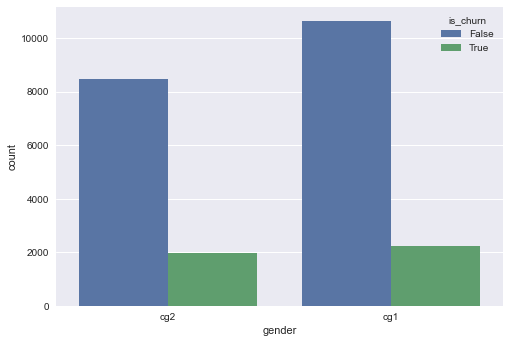

In [23]:
sns.countplot(data=clients_train, x='gender', hue='is_churn')
plt.show()

Não há diferenças significativas entre as distribuições de gênero.

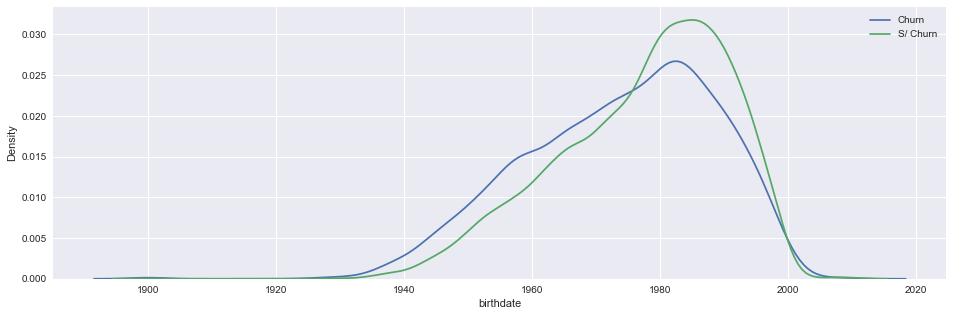

In [24]:
plt.figure(figsize=(16,5))
sns.kdeplot(clients_train[clients_train['is_churn']==True]['birthdate'].str[:4].astype(int))
sns.kdeplot(clients_train[clients_train['is_churn']==False]['birthdate'].str[:4].astype(int))
plt.legend(labels=["Churn","S/ Churn"])
plt.show()

É possível observar uma tendência de que pessoas de mais idade gerem mais churn. 

#### Product

In [25]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12659 entries, 0 to 12658
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_id    12659 non-null  object
 1   category_lv0  12659 non-null  object
 2   category_lv1  12659 non-null  object
 3   category_lv2  12659 non-null  object
 4   category_lv3  12659 non-null  object
 5   category_lv4  12659 non-null  object
dtypes: object(6)
memory usage: 593.5+ KB


In [26]:
product.isna().mean()

product_id      0.0
category_lv0    0.0
category_lv1    0.0
category_lv2    0.0
category_lv3    0.0
category_lv4    0.0
dtype: float64

In [27]:
product

,product_id,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,px01237,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:04846
1,px11510,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:01337
2,px03782,mk38,mk38:072,mk38:072:019,mk38:072:019:066,mk38:072:019:066:02321
3,px04092,mk38,mk38:072,mk38:072:019,mk38:072:019:054,mk38:072:019:054:06035
4,px07429,mk38,mk38:072,mk38:072:078,mk38:072:078:182,mk38:072:078:182:07218
...,...,...,...,...,...,...
12654,px11965,mk35,mk35:072,mk35:072:122,mk35:072:122:182,mk35:072:122:182:00392
12655,px05192,mk35,mk35:072,mk35:072:122,mk35:072:122:182,mk35:072:122:182:02028
12656,px05391,mk38,mk38:107,mk38:107:357,mk38:107:357:182,mk38:107:357:182:08006
12657,px00861,mk35,mk35:072,mk35:072:177,mk35:072:177:182,mk35:072:177:182:03018


In [28]:
product.describe()

,product_id,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
count,12659,12659,12659,12659,12659,12659
unique,12659,52,296,893,1218,10763
top,px08623,mk17,mk21:089,mk03:092:378,mk03:092:378:103,mk35:072:177:182:09721
freq,1,1273,563,237,237,10


A `category_lv4` é muito específica, de forma que existe quase uma categoria por produto disponível. Dentro da base, a maior repetição é que 10 produtos compartilham a mesma `category_lv4`.

#### Orders

In [29]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168472 entries, 0 to 168471
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        168472 non-null  object 
 1   client_id       168472 non-null  object 
 2   product_id      168472 non-null  object 
 3   datetime        168472 non-null  object 
 4   units           168472 non-null  float64
 5   price           168472 non-null  float64
 6   payment_method  168472 non-null  object 
 7   installments    36545 non-null   float64
 8   delivery_days   89642 non-null   float64
 9   delivery_state  168472 non-null  object 
 10  device          168472 non-null  object 
 11  source          168472 non-null  object 
dtypes: float64(4), object(8)
memory usage: 15.4+ MB


In [30]:
orders.isna().mean()

order_id          0.000000
client_id         0.000000
product_id        0.000000
datetime          0.000000
units             0.000000
price             0.000000
payment_method    0.000000
installments      0.783080
delivery_days     0.467912
delivery_state    0.000000
device            0.000000
source            0.000000
dtype: float64

In [31]:
orders.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99], include='all').T

,count,unique,top,freq,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
order_id,168472,133209,ox064456,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
client_id,168472,38821,cx33292,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,168472,12535,px10485,1875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
datetime,168472,102263,2019-11-29 10:29:00,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
units,168472.0,NaN,NaN,NaN,1.228846,1.504511,0.0,0.190946,1.0,1.0,1.0,1.0,2.0,6.0,110.0
price,168472.0,NaN,NaN,NaN,451.384291,857.76928,-8999.0,-1499.9,-98.9,39.9,162.58,699.0,2050.0,3499.0,25648.9
payment_method,168472,14,pm05,131927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installments,36545.0,NaN,NaN,NaN,4.551293,4.704385,1.0,1.0,1.0,1.0,3.0,7.0,12.0,24.0,24.0
delivery_days,89642.0,NaN,NaN,NaN,7.017938,6.855334,0.0,0.0,0.0,2.0,5.0,9.0,20.0,32.0,165.0
delivery_state,168472,26,st07,97820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Entire dataset

Deste ponto em diante, trabalharemos com os dados mesclados, para avaliar as ordens realizadas pelos clientes do dataset de treino.

In [32]:
train_merged = pd.merge(pd.merge(clients_train, orders, on='client_id'), product, on='product_id').copy()

In [33]:
pd.set_option('display.max_columns',None)

In [34]:
train_merged.head()

,client_id,birthdate,state,gender,is_churn,order_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,cx05072,1972-03-22,st25,cg2,False,ox008433,px04611,2019-10-07 15:20:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
1,cx09976,1979-12-23,st25,cg1,False,ox076724,px04611,2019-07-31 16:06:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
2,cx03223,1969-03-22,st15,cg2,False,ox089080,px04611,2019-01-18 12:43:00,1.0,49.89,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
3,cx38788,1987-11-11,st25,cg1,False,ox000246,px04611,2019-06-21 11:22:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
4,cx00593,1982-07-01,st15,cg1,False,ox040114,px04611,2019-07-01 18:22:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294


In [35]:
train_merged.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,units,price,installments,delivery_days
count,101005.000000,101005.000000,21991.000000,53813.000000
mean,1.228586,447.517332,4.531990,6.916656
std,1.564544,855.590526,4.694589,6.779945
min,0.000100,-8999.000000,1.000000,0.000000
1%,0.190200,-1515.000000,1.000000,0.000000
5%,1.000000,-98.908000,1.000000,0.000000
10%,1.000000,5.000000,1.000000,2.000000
25%,1.000000,39.900000,1.000000,2.000000
50%,1.000000,163.010000,3.000000,5.000000
75%,1.000000,699.000000,7.000000,9.000000


In [36]:
train_merged.describe(include='object')

,client_id,birthdate,state,gender,order_id,product_id,datetime,payment_method,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
count,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005
unique,23292,13046,27,2,80190,10145,67735,14,24,9,16,51,277,814,1107,8674
top,cx04375,1990-01-01,st15,cg1,ox036282,px03347,2019-11-29 10:29:00,pm05,st07,dv9,sc08,mk21,mk21:089,mk21:089:468,mk21:089:468:103,mk21:127:505:103:00668
freq,98,194,35017,58145,5,1133,30,79014,58422,58404,58406,17503,12161,7031,7031,1133


In [37]:
auxiliar = pd.merge(train_merged.groupby('client_id')[['units']].sum().reset_index(),
                    clients_train[['client_id', 'is_churn']], on='client_id')   

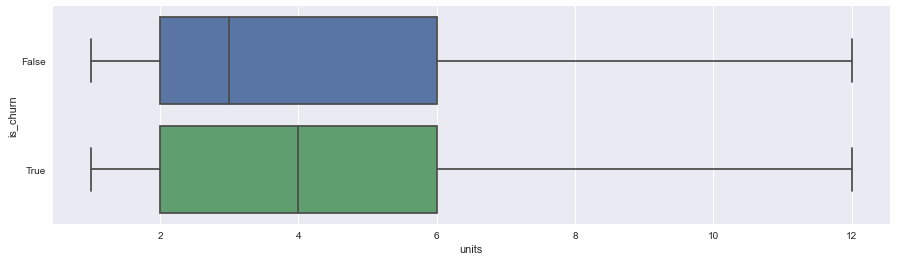

In [38]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=auxiliar, x='units', y='is_churn', orient='h', showfliers=False)
plt.show()

Parece haver uma diferença entre a soma de unidades compradas dos clientes que são identificados como churn e os que não são.

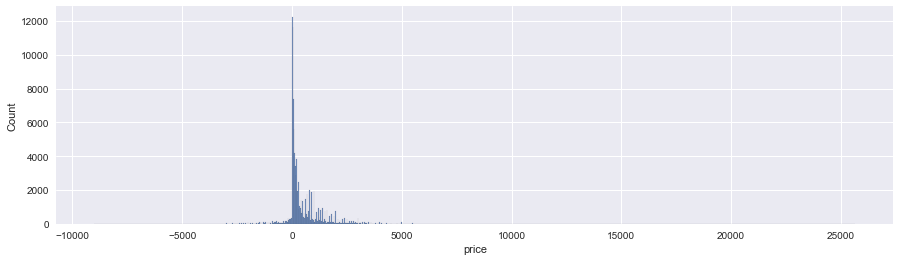

In [39]:
plt.figure(figsize=(15, 4))
sns.histplot(data=train_merged, x='price')
plt.show()

Faremos uma breve investigação nas transações com valores negativos

In [40]:
train_merged[train_merged['price']<=0]

,client_id,birthdate,state,gender,is_churn,order_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
9,cx03363,1974-01-31,st25,cg2,True,ox062213,px12305,2019-10-10 14:21:00,1.00000,-69.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:292,mk04:292:246,mk04:292:246:103,mk04:292:246:103:04338
23,cx03836,1966-08-14,st15,cg1,False,ox090390,px11147,2019-02-08 17:29:00,1.00000,-54.92,pm05,NaN,NaN,st07,dv9,sc08,mk29,mk29:039,mk29:039:103,mk29:039:103:103,mk29:039:103:103:06602
38,cx35550,1994-06-16,st22,cg2,False,ox084595,px11147,2019-03-11 14:52:00,1.00000,-42.58,pm05,NaN,NaN,st22,dv3,sc12,mk29,mk29:039,mk29:039:103,mk29:039:103:103,mk29:039:103:103:06602
41,cx08267,1994-01-16,st25,cg1,True,ox127169,px11147,2019-01-28 17:33:00,1.00000,-49.00,pm05,NaN,NaN,st07,dv9,sc08,mk29,mk29:039,mk29:039:103,mk29:039:103:103,mk29:039:103:103:06602
52,cx28435,1943-04-03,st25,cg1,False,ox025288,px05603,2019-11-30 09:57:00,1.00000,-269.90,pm05,NaN,NaN,st07,dv9,sc08,mk29,mk29:171,mk29:171:103,mk29:171:103:103,mk29:171:103:103:03316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100994,cx23420,1973-10-03,st15,cg1,False,ox095310,px00775,2019-06-07 13:46:00,1.00000,-251.10,pm05,NaN,NaN,st15,dv3,sc12,mk52,mk52:059,mk52:059:103,mk52:059:103:103,mk52:059:103:103:09707
100996,cx02028,1971-01-28,st02,cg2,False,ox057176,px09366,2019-12-02 13:21:00,1.00000,-1200.00,pm05,NaN,NaN,st07,dv9,sc08,mk27,mk27:112,mk27:112:544,mk27:112:544:103,mk27:112:544:103:08008
100998,cx02028,1971-01-28,st02,cg2,False,ox072070,px09366,2019-12-07 11:43:00,1.00000,-1278.00,pm05,NaN,NaN,st07,dv9,sc08,mk27,mk27:112,mk27:112:544,mk27:112:544:103,mk27:112:544:103:08008
101001,cx33764,1987-10-30,st15,cg2,False,ox119488,px04922,2019-01-09 18:29:00,0.16184,-165.84,pm05,NaN,NaN,st07,dv9,sc08,mk13,mk13:280,mk13:280:260,mk13:280:260:103,mk13:280:260:103:10627


In [41]:
train_merged[train_merged['price']<=0]['is_churn'].value_counts(normalize=True)

False    0.787791
True     0.212209
Name: is_churn, dtype: float64

In [42]:
auxiliar = train_merged.groupby('client_id')[['price']].apply(lambda x: (x < 0).mean())

In [43]:
auxiliar = pd.merge(auxiliar[['price']].reset_index(),
                    clients_train[['client_id', 'is_churn']], on='client_id')  

In [44]:
auxiliar.describe()

,price
count,23292.000000
mean,0.034954
std,0.096954
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.800000


Uma vez que a grande maior parte dos usuários não realizaram transações com valores negativos, vamos plotar apenas os que realizaram, para avaliar se ele é um fator significativo quando ocorre.

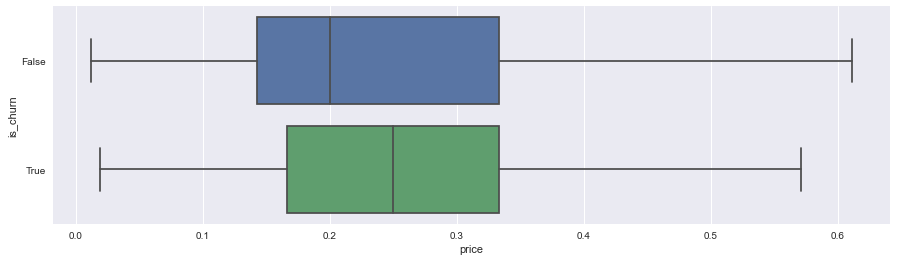

In [45]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=auxiliar[auxiliar.price > 0], x='price', y='is_churn', orient='h', showfliers=False)
plt.show()

Existe uma diferença entre a distribuição dos que churnam ou não.

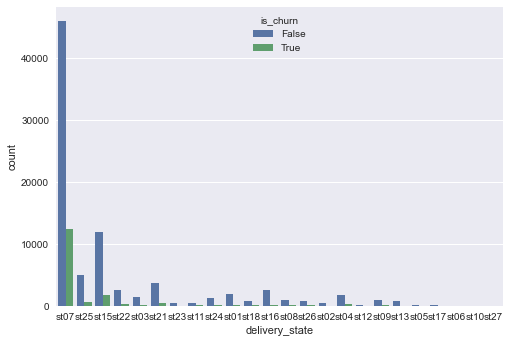

In [46]:
sns.countplot(data=train_merged, x='delivery_state', hue='is_churn')
plt.show()

Apesar de termos observado que muitos clientes pertencem ao estado st15, a maioria das ordens são entregues no estado st07.

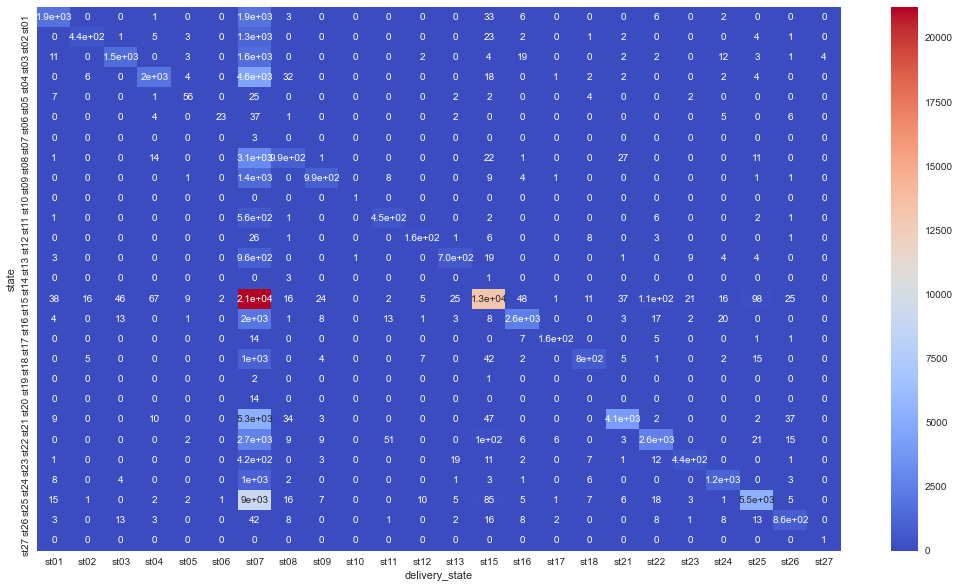

In [47]:
plt.figure(figsize=(18,10))
sns.heatmap(pd.crosstab(index=[train_merged['state']], columns=[train_merged['delivery_state']], normalize=False), 
            annot=True,cmap='coolwarm')
plt.show()

É interessante observar em geral as ordens são entregues no próprio estado do usuário que realizou a comopra ou no estado st15. Uma teoria é que este estado possa ser um destino intermediário, onde a partir dele é feita a entrega final.

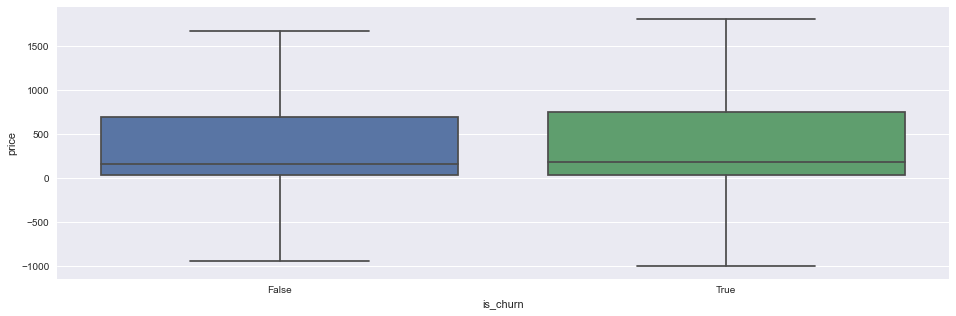

In [48]:
plt.figure(figsize=(16,5))
sns.boxplot(data=train_merged, y='price', x='is_churn', showfliers=False)
plt.show()

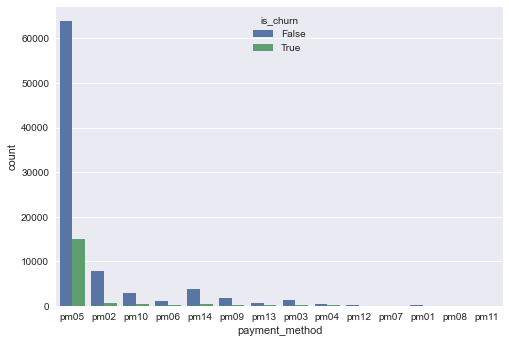

In [49]:
sns.countplot(data=train_merged, x='payment_method', hue='is_churn')
plt.show()

Anteriormente pudemos observar que quase 80% dos dados de `installments` são nulos. <br>
Iremos investigar os dados não nulos.

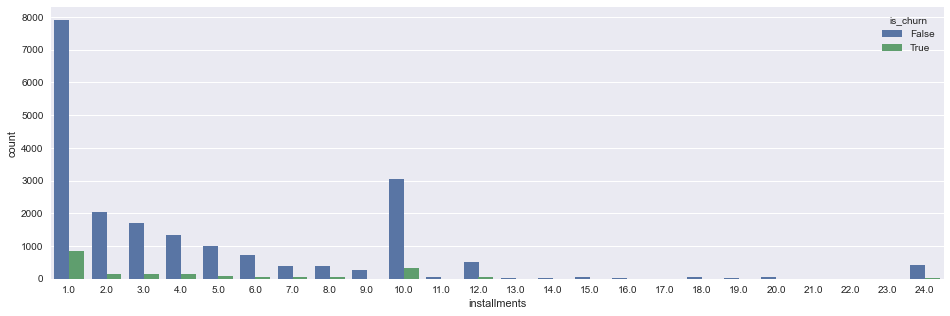

In [50]:
plt.figure(figsize=(16,5))
sns.countplot(data=train_merged, x='installments', hue='is_churn')
plt.show()

Uma teoria possível é que os dados nulos sejam pagos à vista, enquanto os demais são pagos no crédito (seja em uma parcela seja parcelando em diversas).

In [51]:
auxiliar = pd.merge(train_merged.groupby('client_id')[['installments']].mean().reset_index(),
                    clients_train[['client_id', 'is_churn']], on='client_id')   

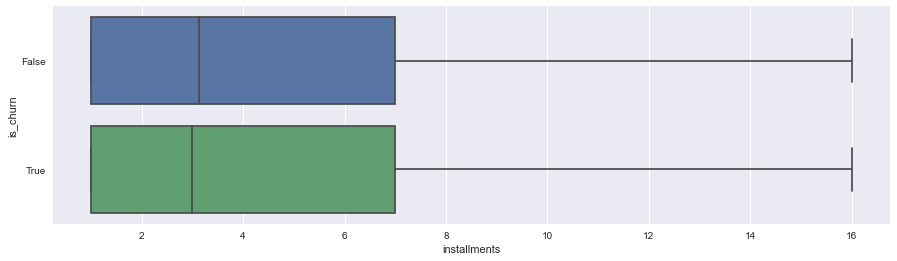

In [52]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=auxiliar, x='installments', y='is_churn', orient='h', showfliers=False)
plt.show()

In [53]:
auxiliar = train_merged.copy()
auxiliar['installments'].fillna(0, inplace=True)

In [54]:
auxiliar = pd.merge(auxiliar.groupby('client_id')[['installments']].mean().reset_index(),
                    clients_train[['client_id', 'is_churn']], on='client_id')  

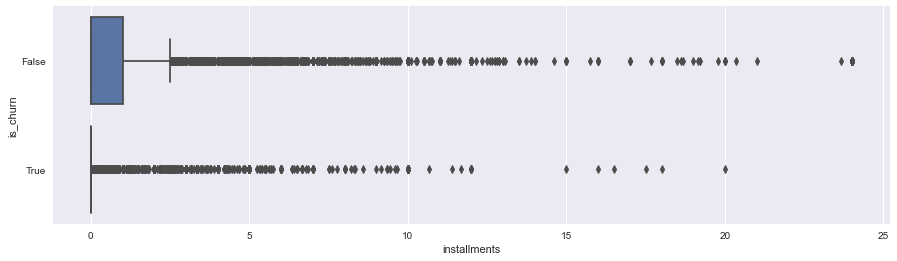

In [55]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=auxiliar, x='installments', y='is_churn', orient='h')
plt.show()

Assim, é evidente que os usuários que parcelam suas compras mais raramente realizam churn.

Assim como no caso dos `installments`, o `delivery_days` possui diversos dados faltantes.<br>
A hipótese de negócios é que estes são itens comprados e retirados pelo usuário, não sendo entregues pela empresa. 

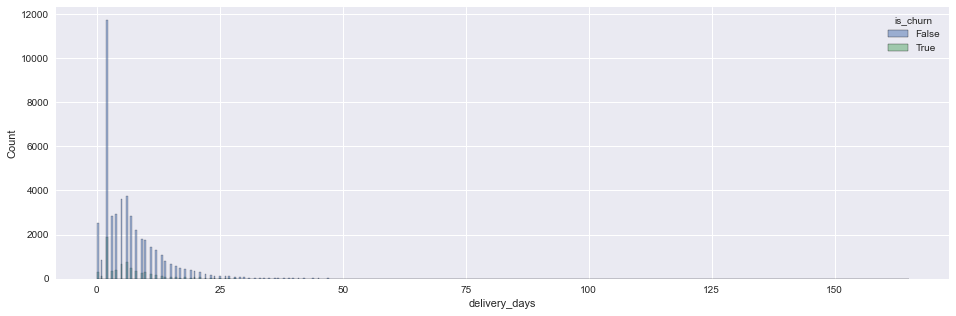

In [56]:
plt.figure(figsize=(16,5))
sns.histplot(data=train_merged, x='delivery_days', hue='is_churn')
plt.show()

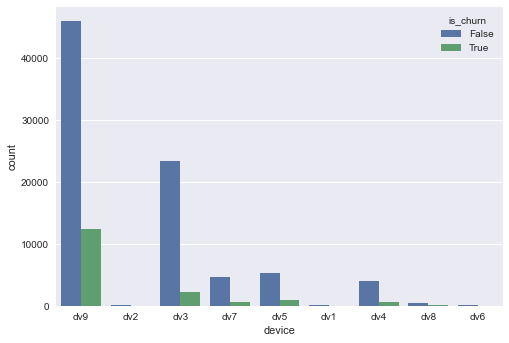

In [57]:
sns.countplot(data=train_merged, x='device', hue='is_churn')
plt.show()

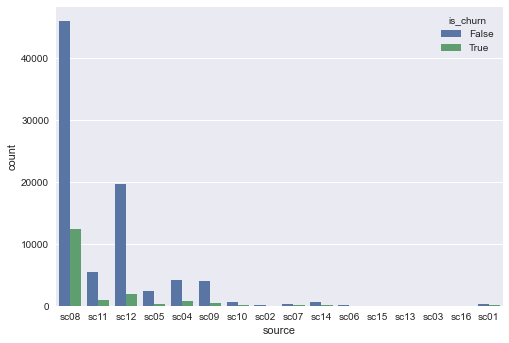

In [58]:
sns.countplot(data=train_merged, x='source', hue='is_churn')
plt.show()

## 5. Pré-Processamento<a name="preprocessing"></a>

Para realizar uma boa feature engineering, nesta etapa de pré-processamento e limpeza:
- Transformaremos o `birthday` ao formato datetime
- Preencheremos os dados faltantantes em 0, conforme teorias anteriores
- Será criada uma nova feature, `negative`, que será utilizada na feature engineering. Ela representa a quantidade de unidades identificadas com um valor negativo
- Não será removida nenhuma feature, para que seja realizada uma análise de importância das features desenvolvidas na próxima etapa

In [59]:
orders['datetime'] = pd.to_datetime(orders['datetime'])
clients_train['birthdate'] = pd.to_datetime(clients_train['birthdate'])
clients_test['birthdate'] = pd.to_datetime(clients_test['birthdate'])
clients_challenge['birthdate'] = pd.to_datetime(clients_challenge['birthdate'])

In [60]:
orders['installments'].fillna(0, inplace=True)
orders['delivery_days'].fillna(0, inplace=True)

In [61]:
orders['negative'] = orders.apply(lambda row: 1*row['units'] if row['price']<0 else 0, axis=1)

## 6. Feature Engineering <a name="featureengineering"></a>

Para se extrair informações do dataset, a _feature enginering_ terá como objetivo agrupar os dados por cliente, realizando uma contagem de diferentes tipos de categorias dentro dos grupos e uma extração da média, desvio padrão, valores mínimos, máximos e quartis das variáveis numéricas. A data de nascimento será convertida em idade. Ainda, será feita uma soma do total de unidades, total de volume de gastos e total de unidades com ordens negativas.

Desta forma, as features finais do dataset serão:

- `gender_g1`: _bool_ calculada a partir do `gender`
- `client_age`: calculada a partir do `birthdate`
- `sum_units`: total de itens comprados em 2019
- `sum_volume`: total gasto em compras em 2019
- `sum_negative`: total de unidades com transações negativas em compras em 2019
- `count_orders_states_ne`: quantidade de compras entregando em estados diferentes ao do cliente
- `count_orders_states_eq`: quantidade de compras entregando em estados iguais ao do cliente
- `count_product_id`: quantidade de produtos diferentes presentes nas compras
- `count_device`: quantidade de devices diferentes utilizados nas compras
- `count_source`: quantidade de canais diferentes que geraram o _lead_
- `count_payment_method`: quantidade de meios de pagamento em compras
- `count_category_lv0`: quantidade de categorias diferentes (nível 0) em compras
- `count_category_lv1`: quantidade de categorias diferentes (nível 1) em compras
- `count_category_lv2`: quantidade de categorias diferentes (nível 2) em compras
- `count_category_lv3`: quantidade de categorias diferentes (nível 3) em compras
- `count_category_lv4`: quantidade de categorias diferentes (nível 4) em compras
- `price_avg`: média dos preços pagos em cada item comprado
- `price_std`: desvio padrão dos preços pagos em cada item comprado
- `price_min`: mínimo dos preços pagos em cada item comprado
- `price_25p`: quartil 25% dos preços pagos em cada item comprado
- `price_50p`: quartil 50% dos preços pagos em cada item comprado
- `price_75p`: quartil 75% dos preços pagos em cada item comprado
- `price_max`: máximo dos preços pagos em cada item comprado
- `delivery_days_avg`: média da quantidade de dias para entregar (prazo)
- `delivery_days_std`: desvio padrão da quantidade de dias para entregar (prazo)
- `delivery_days_min`: mínimo da quantidade de dias para entregar (prazo)
- `delivery_days_25p`: quartil 25% da quantidade de dias para entregar (prazo)
- `delivery_days_50p`: quartil 50% da quantidade de dias para entregar (prazo)
- `delivery_days_75p`: quartil 75% da quantidade de dias para entregar (prazo)
- `delivery_days_max`: máximo da quantidade de dias para entregar (prazo)
- `installments_avg`: média da quantidade de parcelas de pagamento
- `installments_std`: desvio padrão da quantidade de parcelas de pagamento
- `installments_min`: mínimo da quantidade de parcelas de pagamento
- `installments_25p`: quartil 25% da quantidade de parcelas de pagamento
- `installments_50p`: quartil 50% da quantidade de parcelas de pagamento
- `installments_75p`: quartil 75% da quantidade de parcelas de pagamento
- `installments_max`: máximo da quantidade de parcelas de pagamento

In [62]:
clients_train.set_index('client_id', inplace=True)
clients_test.set_index('client_id', inplace=True)
clients_challenge.set_index('client_id', inplace=True)
orders.set_index('order_id', inplace=True)
product.set_index('product_id', inplace=True)

In [63]:
class OrderAggregatorFeaturesTransform(BaseEstimator, TransformerMixin):
    """ Classe base para FeaturesTransformers que usam os dados de Histórico de Vendas para extrair os dados.
    """
    
    def __init__(self, orders_table, columns=None, product_table=None, imputer=None):
        
        self.work_table = None
        if product_table is not None:
            self.refr_table = pd.merge(
                orders_table,
                product_table.reset_index(),
                on='product_id'
            )
        else:
            self.refr_table = orders_table.copy()
        if columns is not None:
            self.refr_table = self.refr_table[['client_id', *columns]]
        self._reset_database()
        self.imputer = imputer
        self.columns = columns

    def _reset_database(self):
        self.work_table = self.refr_table.copy()
        return self

    def _process_client(self, df):
        return df.set_index('client_id')

    def _select_orders(self, df):
        idx = self.work_table['client_id'].isin(df.index)
        return self.work_table[idx]

    def fit(self, X, y=None, **fit_params):
        if self.imputer is not None:
            self._reset_database()
            self.imputer.fit(self._select_orders(X)[self.columns])
            self.work_table.loc[:, self.columns] = self.imputer.transform(self.work_table[self.columns])
        return self
    
    def transform(self, X):
        return self._select_orders(X).groupby('client_id').apply(self._process_client)

In [64]:
class UniqueCounterTransform(OrderAggregatorFeaturesTransform):

    def _process_client(self, df):
        tmp = super()._process_client(df)
        return tmp.apply(lambda x: len(x.unique())).rename(index=lambda x: f'count_{x}')

In [65]:
class SumValuesTransform(OrderAggregatorFeaturesTransform):

    def _process_client(self, df):
        tmp = super()._process_client(df)
        return tmp.sum().rename(index=lambda x: f'sum_{x}')

In [66]:
class DistributionTransform(OrderAggregatorFeaturesTransform):

    def _process_client(self, df):
        tmp = (super()
               ._process_client(df)
               .describe()
               .drop(index='count')
               .rename(index=lambda c: c.replace('%', 'p')) 
               .rename(index={'mean': 'avg'})
               .unstack())
        tmp.index = tmp.index.map('_'.join)
        return tmp

In [67]:
class CountStateMatchesTransform(OrderAggregatorFeaturesTransform):
    
    def _process_client(self, df):
        tmp = df.set_index('client_id')[['state', 'delivery_state']]
        return pd.Series({
            'count_orders_states_eq': (tmp.state == tmp.delivery_state).sum(),
            'count_orders_states_ne': (tmp.state != tmp.delivery_state).sum()
        })

    def transform(self, X):
        return (
            pd.merge(
                self._select_orders(X),
                X[['state']].reset_index(),
                on='client_id'
            ).groupby('client_id').apply(self._process_client)
        )

In [68]:
class FeatureEngineeringTransform(BaseEstimator, TransformerMixin):

    def __init__(self, orders_table, product_table):
        orders_table['volume'] = orders_table.units * orders_table.price
        self._transf_sum = SumValuesTransform(orders_table=orders_table, columns=['units', 'volume', 'negative'])
        self._transf_stt = CountStateMatchesTransform(orders_table=orders_table[['client_id', 'delivery_state']])
        self._transf_cnt = UniqueCounterTransform(
            orders_table=orders_table, 
            product_table=product, 
            columns=['product_id', 'device', 'source', 'payment_method', 
                     'category_lv0', 'category_lv1', 'category_lv2', 'category_lv3', 'category_lv4']
        )
        self._transf_dst_med = DistributionTransform(
            orders_table=orders_table, 
            product_table=product, 
            columns=['price', 'delivery_days'],
            imputer=SimpleImputer(strategy='median')
        )
        self._transf_dst_one = DistributionTransform(
            orders_table=orders_table, 
            product_table=product, 
            columns=['installments'],
            imputer=SimpleImputer(strategy='constant', fill_value=1)
        )
        
    def fit(self, X, y=None, **fit_params): 
        self._transf_dst_med.fit(X)
        self._transf_dst_one.fit(X)
        return self
    
    def transform(self, X):
        output = (X[['gender']] == 'cg1').rename(columns={'gender': 'gender_cg1'})
        output['client_age'] = 2022 - X.birthdate.dt.year
        output = output.join(self._transf_sum.transform(X))
        output = output.join(self._transf_stt.transform(X))
        output = output.join(self._transf_cnt.transform(X))
        output = output.join(self._transf_dst_med.transform(X))
        output = output.join(self._transf_dst_one.transform(X))
        output.fillna(0, inplace=True)
        
        return output

Após criação das classes e funções a serem aplicadas, os 3 datasets (treino, teste e desafio) serão transformados.

In [69]:
%%time
feateng = FeatureEngineeringTransform(orders, product).fit(clients_train)

Wall time: 622 ms


Após transformações, os dataset serão normalizados utilizando o StandardScaler.

#### Treino

In [70]:
%%time
train_dataset = feateng.transform(clients_train)

Wall time: 4min 22s


In [71]:
train_dataset

,gender_cg1,client_age,sum_units,sum_volume,sum_negative,count_orders_states_eq,count_orders_states_ne,count_product_id,count_device,count_source,count_payment_method,count_category_lv0,count_category_lv1,count_category_lv2,count_category_lv3,count_category_lv4,price_avg,price_std,price_min,price_25p,price_50p,price_75p,price_max,delivery_days_avg,delivery_days_std,delivery_days_min,delivery_days_25p,delivery_days_50p,delivery_days_75p,delivery_days_max,installments_avg,installments_std,installments_min,installments_25p,installments_50p,installments_75p,installments_max
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cx05072,False,50,2.00000,119.800000,0.00000,0,2,2,1,1,1,1,2,2,2,2,59.900000,14.142136,49.90,54.9000,59.90,64.90,69.90,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cx03836,True,56,8.00000,625.720000,1.00000,0,7,6,1,1,1,3,6,6,6,6,78.108571,83.710286,-54.92,57.4100,78.96,89.00,229.90,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cx08472,True,68,3.00000,2832.920000,0.00000,0,3,2,1,1,1,2,2,2,2,2,944.306667,1575.138551,34.90,34.9000,34.90,1399.01,2763.12,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cx12946,True,67,1.00000,69.900000,0.00000,0,1,1,1,1,1,1,1,1,1,1,69.900000,0.000000,69.90,69.9000,69.90,69.90,69.90,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cx19045,False,64,16.00000,794.840000,1.00000,1,14,14,2,2,1,5,5,10,10,14,48.996000,42.163274,-59.00,35.9000,49.90,59.90,144.94,0.066667,0.258199,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx05312,True,41,4.00000,1038.020000,0.00000,0,3,3,1,1,1,3,3,3,3,3,293.006667,266.595462,120.00,139.5000,159.00,379.51,600.02,2.000000,3.464102,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cx02434,False,25,1.00000,1952.900000,0.00000,0,1,1,1,1,1,1,1,1,1,1,1952.900000,0.000000,1952.90,1952.9000,1952.90,1952.90,1952.90,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0
cx16024,True,72,4.00000,1158.000000,0.00000,0,3,3,1,1,1,3,3,3,3,3,326.000000,196.181039,180.00,214.5000,249.00,399.00,549.00,3.666667,6.350853,0.0,0.0,0.0,5.5,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
scale_cols = train_dataset.columns[1:]
scale_cols

Index(['client_age', 'sum_units', 'sum_volume', 'sum_negative',
       'count_orders_states_eq', 'count_orders_states_ne', 'count_product_id',
       'count_device', 'count_source', 'count_payment_method',
       'count_category_lv0', 'count_category_lv1', 'count_category_lv2',
       'count_category_lv3', 'count_category_lv4', 'price_avg', 'price_std',
       'price_min', 'price_25p', 'price_50p', 'price_75p', 'price_max',
       'delivery_days_avg', 'delivery_days_std', 'delivery_days_min',
       'delivery_days_25p', 'delivery_days_50p', 'delivery_days_75p',
       'delivery_days_max', 'installments_avg', 'installments_std',
       'installments_min', 'installments_25p', 'installments_50p',
       'installments_75p', 'installments_max'],
      dtype='object')

In [73]:
scaler = StandardScaler().fit(train_dataset[scale_cols])
scaler

StandardScaler()

In [74]:
train_dataset.loc[:, scale_cols] = scaler.transform(train_dataset.loc[:, scale_cols])

In [75]:
train_dataset = pd.merge(train_dataset, clients_train[['is_churn']], left_index=True, right_index=True)

In [76]:
train_dataset

,gender_cg1,client_age,sum_units,sum_volume,sum_negative,count_orders_states_eq,count_orders_states_ne,count_product_id,count_device,count_source,count_payment_method,count_category_lv0,count_category_lv1,count_category_lv2,count_category_lv3,count_category_lv4,price_avg,price_std,price_min,price_25p,price_50p,price_75p,price_max,delivery_days_avg,delivery_days_std,delivery_days_min,delivery_days_25p,delivery_days_50p,delivery_days_75p,delivery_days_max,installments_avg,installments_std,installments_min,installments_25p,installments_50p,installments_75p,installments_max,is_churn
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cx05072,False,0.347788,-0.294982,-0.654008,-0.297865,-0.480636,-0.159651,-0.483604,-0.541915,-0.538487,-0.543817,-0.894074,-0.460879,-0.482974,-0.483553,-0.481263,-0.812555,-0.772480,-0.077349,-0.409061,-0.665084,-0.880648,-1.005174,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
cx03836,True,0.785662,0.236881,-0.487896,1.066705,-0.480636,1.185909,0.591497,-0.541915,-0.538487,-0.543817,0.224485,1.062056,0.862853,0.823581,0.604620,-0.782043,-0.654318,-0.216128,-0.404884,-0.634847,-0.848710,-0.855742,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
cx08472,True,1.661411,-0.206338,0.236808,-0.297865,-0.480636,0.109461,-0.483604,-0.541915,-0.538487,-0.543817,-0.334794,-0.460879,-0.482974,-0.483553,-0.481263,0.669460,1.878866,-0.097208,-0.442343,-0.704744,0.887357,1.510150,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
cx12946,True,1.588432,-0.383625,-0.670392,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,-0.543817,-0.894074,-0.841612,-0.819431,-0.810337,-0.752733,-0.795798,-0.796500,-0.050869,-0.384100,-0.649220,-0.874022,-1.005174,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
cx19045,False,1.369494,0.946031,-0.432368,1.066705,-0.204918,3.069692,2.741699,1.107626,1.068076,-0.543817,1.343044,0.681322,2.208680,2.130715,2.776386,-0.830827,-0.724886,-0.221530,-0.440679,-0.680948,-0.887275,-0.935090,-0.745459,-0.586107,-0.446246,-0.563174,-0.650624,-0.751254,-0.682934,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx05312,True,-0.309024,-0.117694,-0.352523,-0.297865,-0.480636,0.109461,-0.214829,-0.541915,-0.538487,-0.543817,0.224485,-0.080145,-0.146517,-0.156770,-0.209792,-0.421934,-0.343689,0.015462,-0.268278,-0.507871,-0.463717,-0.510070,-0.331769,0.365760,-0.446246,-0.563174,-0.650624,-0.236448,-0.065866,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
cx02434,False,-1.476688,-0.383625,-0.052135,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,-0.543817,-0.894074,-0.841612,-0.819431,-0.810337,-0.752733,2.359577,-0.796500,2.442177,2.749395,2.337986,1.621390,0.753448,-0.331769,-0.662769,0.077775,-0.081689,-0.234750,-0.408050,-0.559520,4.079241,-0.444198,5.893317,5.147472,4.099024,3.017040,1.87191,False
cx16024,True,1.953327,-0.117694,-0.313129,-0.297865,-0.480636,0.109461,-0.214829,-0.541915,-0.538487,-0.543817,0.224485,-0.080145,-0.146517,-0.156770,-0.209792,-0.366647,-0.463287,0.094901,-0.143471,-0.365094,-0.437888,-0.557720,0.024861,1.222868,-0.446246,-0.563174,-0.650624,0.192557,0.551202,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False


#### Teste

In [77]:
%%time
test_dataset = feateng.transform(clients_test)

Wall time: 1min 27s


In [78]:
test_dataset.loc[:, scale_cols] = scaler.transform(test_dataset.loc[:, scale_cols])

In [79]:
test_dataset = pd.merge(test_dataset, clients_test[['is_churn']], left_index=True, right_index=True)

In [80]:
#test_dataset.to_csv('data/client.test.features.v1.sv')
test_dataset

,gender_cg1,client_age,sum_units,sum_volume,sum_negative,count_orders_states_eq,count_orders_states_ne,count_product_id,count_device,count_source,count_payment_method,count_category_lv0,count_category_lv1,count_category_lv2,count_category_lv3,count_category_lv4,price_avg,price_std,price_min,price_25p,price_50p,price_75p,price_max,delivery_days_avg,delivery_days_std,delivery_days_min,delivery_days_25p,delivery_days_50p,delivery_days_75p,delivery_days_max,installments_avg,installments_std,installments_min,installments_25p,installments_50p,installments_75p,installments_max,is_churn
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cx06840,True,-0.382003,0.325525,-0.557937,-0.297865,-0.480636,1.185909,0.860272,-0.541915,-0.538487,-0.543817,0.224485,-0.080145,1.199310,1.150365,0.876091,-0.831395,-0.769917,-0.095884,-0.438100,-0.690149,-0.896551,-0.995834,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx01931,True,-0.163065,-0.117694,-0.617956,-0.297865,-0.480636,0.109461,-0.214829,-0.541915,-0.538487,-0.543817,-0.894074,-0.841612,-0.146517,-0.156770,-0.209792,-0.798591,-0.703340,-0.110448,-0.438183,-0.680948,-0.847518,-0.949137,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx35431,True,0.858641,-0.383625,-0.667404,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,-0.543817,-0.894074,-0.841612,-0.819431,-0.810337,-0.752733,-0.780549,-0.796500,-0.038821,-0.368956,-0.634783,-0.861963,-0.996675,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx36233,False,1.661411,-0.294982,0.831122,-0.297865,-0.480636,-0.159651,-0.483604,-0.541915,-0.538487,-0.543817,-0.334794,-0.460879,-0.482974,-0.483553,-0.481263,2.977246,3.941515,0.318653,1.721565,2.922736,3.416881,2.939910,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx13540,True,0.858641,-0.117694,-0.632994,-0.297865,-0.480636,0.378573,0.053947,-0.541915,-0.538487,-0.543817,-0.334794,-0.460879,-0.146517,-0.156770,0.061679,-0.835931,-0.768826,-0.105020,-0.444673,-0.684835,-0.887275,-1.014513,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx19119,True,-0.236045,-0.383625,-0.431002,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,-0.543817,-0.894074,-0.841612,-0.819431,-0.810337,-0.752733,0.425967,-0.796500,0.914442,0.829193,0.507430,0.092205,-0.324233,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx21963,False,-0.527961,-0.383625,-0.680537,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,-0.543817,-0.894074,-0.841612,-0.819431,-0.810337,-0.752733,-0.847578,-0.796500,-0.091780,-0.435520,-0.698240,-0.914972,-1.034033,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx37195,False,1.223536,-0.383625,-0.657163,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,-0.543817,-0.894074,-0.841612,-0.819431,-0.810337,-0.752733,-0.728283,-0.796500,0.002474,-0.317053,-0.585303,-0.820629,-0.967545,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False


#### Desafio

In [81]:
%%time
challenge_dataset = feateng.transform(clients_challenge)

Wall time: 1min 56s


In [82]:
challenge_dataset.loc[:, scale_cols] = scaler.transform(challenge_dataset.loc[:, scale_cols])

In [83]:
challenge_dataset

,gender_cg1,client_age,sum_units,sum_volume,sum_negative,count_orders_states_eq,count_orders_states_ne,count_product_id,count_device,count_source,count_payment_method,count_category_lv0,count_category_lv1,count_category_lv2,count_category_lv3,count_category_lv4,price_avg,price_std,price_min,price_25p,price_50p,price_75p,price_max,delivery_days_avg,delivery_days_std,delivery_days_min,delivery_days_25p,delivery_days_50p,delivery_days_75p,delivery_days_max,installments_avg,installments_std,installments_min,installments_25p,installments_50p,installments_75p,installments_max
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cx12525,True,3.266949,-0.029050,-0.569202,-0.297865,-0.480636,0.647685,0.322722,-0.541915,-0.538487,-0.543817,-0.334794,-0.460879,-0.146517,-0.156770,0.333150,-0.786216,-0.718375,-0.130308,-0.415601,-0.622885,-0.828858,-0.952088,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx32280,True,-0.454982,-0.029050,-0.386279,-0.297865,-0.480636,0.378573,0.053947,-0.541915,-0.538487,-0.543817,0.224485,0.300589,0.189939,0.170014,0.061679,-0.527428,-0.412142,-0.123555,-0.365641,-0.461698,-0.519834,-0.576399,-0.331769,0.524874,-0.446246,-0.563174,-0.650624,-0.408050,0.180961,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx00471,False,0.931620,0.414168,-0.257017,1.066705,-0.480636,1.455021,0.591497,-0.541915,-0.538487,-0.543817,0.224485,0.681322,0.526396,0.496797,0.604620,-0.847437,-0.291725,-0.684762,-0.621849,-0.537933,-0.700798,-0.688584,-0.224780,0.130759,-0.446246,-0.563174,-0.130782,0.106756,-0.189280,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx18876,False,0.420767,0.414168,2.153355,-0.297865,-0.480636,1.993244,1.129048,-0.541915,-0.538487,-0.543817,1.343044,1.062056,1.199310,1.150365,1.147562,0.539928,0.559361,-0.136795,-0.209731,0.424144,1.030072,1.076649,-0.438758,0.054339,-0.446246,-0.563174,-0.650624,-0.107747,-0.189280,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx38255,True,1.369494,-0.206338,0.012022,-0.297865,-0.480636,0.109461,-0.214829,-0.541915,-0.538487,-0.543817,0.224485,-0.080145,-0.146517,-0.156770,-0.209792,0.287050,0.796983,0.068448,-0.210018,-0.460279,0.350810,0.609975,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx37820,True,-0.236045,-0.117694,-0.571004,-0.297865,0.346518,-0.697875,-0.214829,-0.541915,-0.538487,-0.543817,0.224485,-0.080145,-0.146517,-0.156770,-0.209792,-0.757815,-0.759821,-0.050869,-0.363298,-0.609560,-0.828964,-0.965014,0.738121,-0.662769,1.387830,1.122022,0.804934,0.449960,0.057547,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx00770,False,0.931620,0.059593,-0.474868,-0.297865,-0.480636,0.378573,0.053947,-0.541915,-0.538487,-0.543817,0.783764,0.300589,0.189939,0.170014,0.061679,-0.768651,-0.687693,-0.130308,-0.415177,-0.622092,-0.805143,-0.920558,-0.759724,-0.662769,-0.446246,-0.563174,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx01686,False,0.347788,0.059593,-0.499174,-0.297865,0.346518,-0.428763,-0.214829,1.107626,1.068076,2.427466,0.224485,-0.080145,-0.146517,-0.156770,-0.209792,-0.708673,-0.527474,-0.102809,-0.430374,-0.682534,-0.796099,-0.735076,-0.545746,-0.420342,-0.446246,-0.382617,-0.442687,-0.536752,-0.559520,0.572104,0.640722,-0.21948,0.524226,0.537615,0.513700,0.684105


## 7. Análise Exploratória Final <a name="finaleda"></a>

In [84]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23292 entries, cx05072 to cx00861
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender_cg1              23292 non-null  bool   
 1   client_age              23292 non-null  float64
 2   sum_units               23292 non-null  float64
 3   sum_volume              23292 non-null  float64
 4   sum_negative            23292 non-null  float64
 5   count_orders_states_eq  23292 non-null  float64
 6   count_orders_states_ne  23292 non-null  float64
 7   count_product_id        23292 non-null  float64
 8   count_device            23292 non-null  float64
 9   count_source            23292 non-null  float64
 10  count_payment_method    23292 non-null  float64
 11  count_category_lv0      23292 non-null  float64
 12  count_category_lv1      23292 non-null  float64
 13  count_category_lv2      23292 non-null  float64
 14  count_category_lv3      23292 non-n

In [85]:
train_dataset.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,client_age,sum_units,sum_volume,sum_negative,count_orders_states_eq,count_orders_states_ne,count_product_id,count_device,count_source,count_payment_method,count_category_lv0,count_category_lv1,count_category_lv2,count_category_lv3,count_category_lv4,price_avg,price_std,price_min,price_25p,price_50p,price_75p,price_max,delivery_days_avg,delivery_days_std,delivery_days_min,delivery_days_25p,delivery_days_50p,delivery_days_75p,delivery_days_max,installments_avg,installments_std,installments_min,installments_25p,installments_50p,installments_75p,installments_max
count,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04,2.329200e+04
mean,6.455757e-16,1.173603e-15,-1.353923e-16,-3.028375e-16,-1.221935e-14,-3.089911e-15,-1.517519e-15,7.814279e-15,1.154002e-14,1.543963e-14,-1.518573e-16,-6.660480e-16,2.606998e-15,5.224035e-16,-7.479038e-16,-1.556407e-16,2.894516e-15,-6.684956e-17,8.658186e-17,7.852878e-17,2.556934e-16,-5.810236e-17,-1.328158e-14,9.877691e-15,-2.082138e-14,1.759035e-15,6.880218e-15,-2.157291e-14,3.087432e-15,-1.767382e-14,1.798639e-14,1.038773e-15,-1.628762e-14,-6.368811e-15,1.323520e-14,1.876682e-14
std,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00
min,-2.425416e+00,-3.836254e-01,-4.379565e+00,-2.978647e-01,-4.806363e-01,-6.978747e-01,-7.523791e-01,-5.419153e-01,-5.384869e-01,-5.438167e-01,-8.940739e-01,-8.416123e-01,-8.194308e-01,-8.103368e-01,-7.527333e-01,-3.621660e+00,-7.964999e-01,-1.205787e+01,-9.643101e+00,-7.898945e+00,-4.536965e+00,-1.070457e+00,-7.597243e-01,-6.627691e-01,-4.462465e-01,-5.631738e-01,-6.506241e-01,-7.512543e-01,-8.063476e-01,-4.460970e-01,-4.441979e-01,-2.194802e-01,-2.916413e-01,-3.527369e-01,-4.358427e-01,-5.037003e-01
1%,-1.622646e+00,-3.836254e-01,-6.868085e-01,-2.978647e-01,-4.806363e-01,-6.978747e-01,-7.523791e-01,-5.419153e-01,-5.384869e-01,-5.438167e-01,-8.940739e-01,-8.416123e-01,-8.194308e-01,-8.103368e-01,-7.527333e-01,-9.129306e-01,-7.964999e-01,-3.584491e+00,-2.148454e+00,-7.559748e-01,-9.444915e-01,-1.051871e+00,-7.597243e-01,-6.627691e-01,-4.462465e-01,-5.631738e-01,-6.506241e-01,-7.512543e-01,-8.063476e-01,-4.460970e-01,-4.441979e-01,-2.194802e-01,-2.916413e-01,-3.527369e-01,-4.358427e-01,-5.037003e-01
5%,-1.330730e+00,-3.836254e-01,-6.671083e-01,-2.978647e-01,-4.806363e-01,-6.978747e-01,-7.523791e-01,-5.419153e-01,-5.384869e-01,-5.438167e-01,-8.940739e-01,-8.416123e-01,-8.194308e-01,-8.103368e-01,-7.527333e-01,-8.563375e-01,-7.964999e-01,-1.333669e+00,-5.004200e-01,-7.206081e-01,-9.070169e-01,-1.015354e+00,-7.597243e-01,-6.627691e-01,-4.462465e-01,-5.631738e-01,-6.506241e-01,-7.512543e-01,-8.063476e-01,-4.460970e-01,-4.441979e-01,-2.194802e-01,-2.916413e-01,-3.527369e-01,-4.358427e-01,-5.037003e-01
25%,-7.468978e-01,-2.949817e-01,-5.387470e-01,-2.978647e-01,-4.806363e-01,-6.978747e-01,-4.836039e-01,-5.419153e-01,-5.384869e-01,-5.438167e-01,-8.940739e-01,-8.416123e-01,-4.829740e-01,-4.835532e-01,-4.812626e-01,-6.650060e-01,-7.604513e-01,-1.367952e-01,-4.264717e-01,-6.032139e-01,-7.282716e-01,-8.090449e-01,-7.597243e-01,-6.627691e-01,-4.462465e-01,-5.631738e-01,-6.506241e-01,-7.512543e-01,-8.063476e-01,-4.460970e-01,-4.441979e-01,-2.194802e-01,-2.916413e-01,-3.527369e

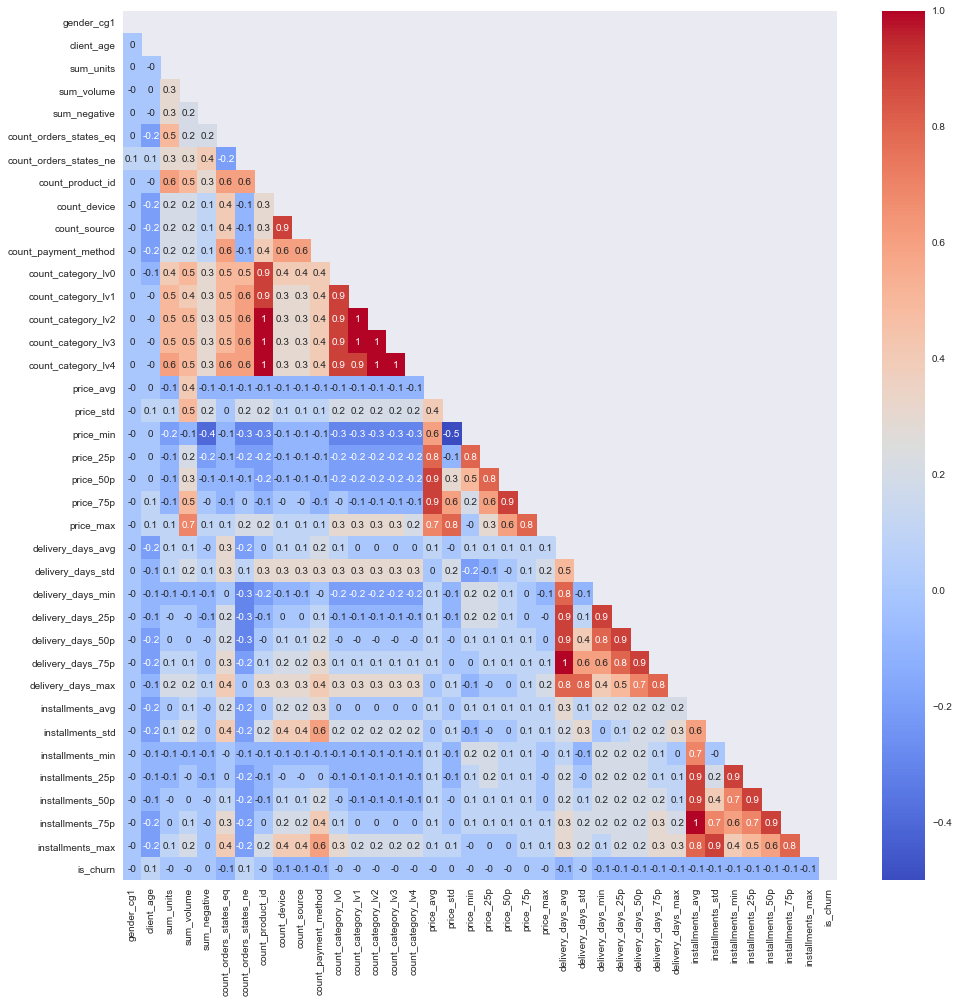

In [86]:
plt.figure(figsize=(16,16))
mask = np.triu(np.ones_like(train_dataset.corr(), dtype=bool))

sns.heatmap(train_dataset.corr().round(1), annot=True, mask=mask, cmap='coolwarm')
plt.show()

Para melhor visualizar o poder preditivo das features, plotaremos um box plot com os valores de cada feature e os targets.

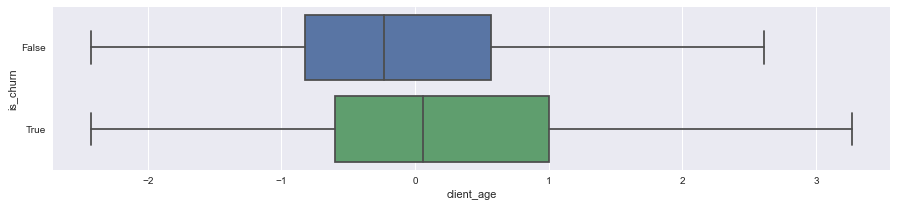

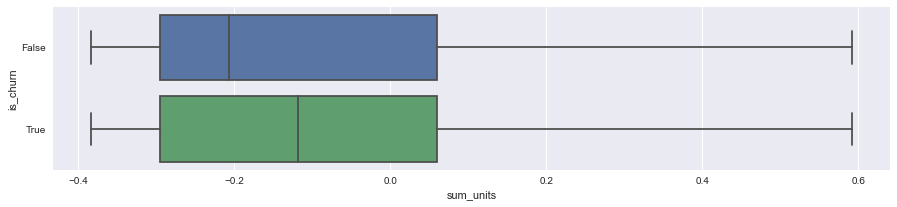

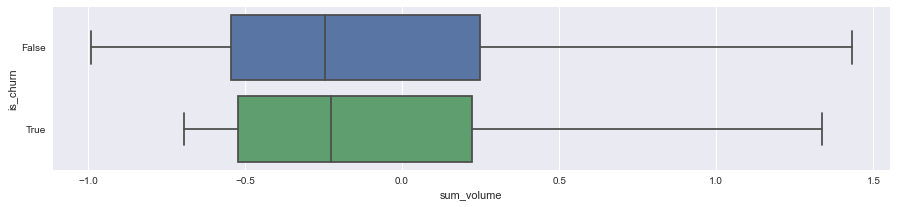

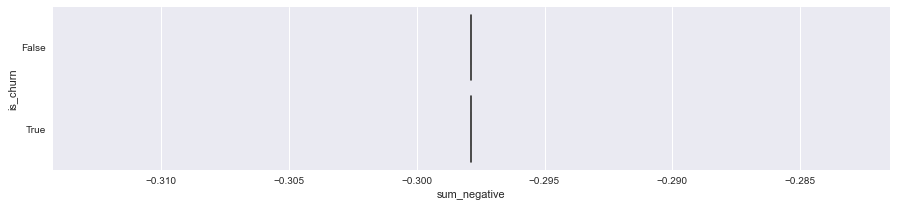

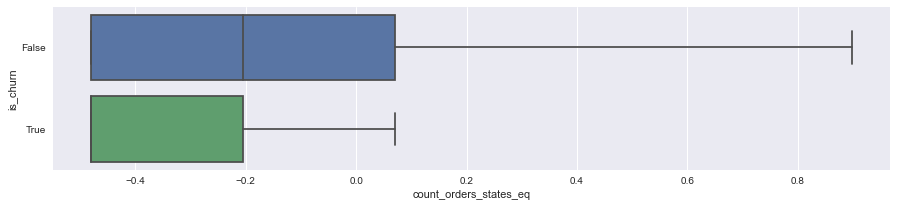

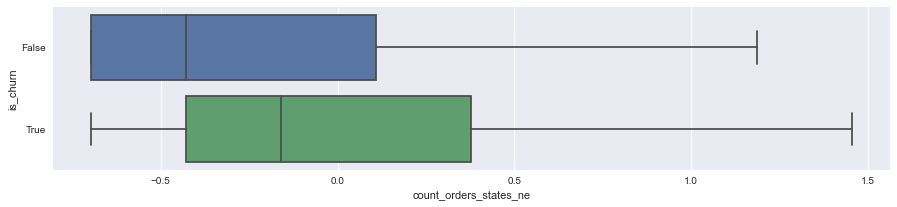

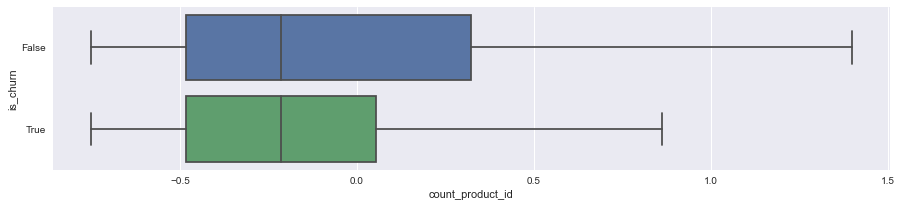

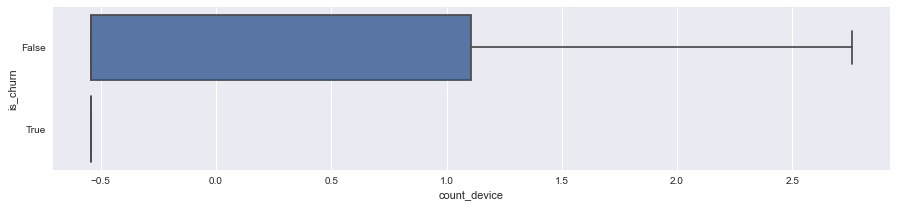

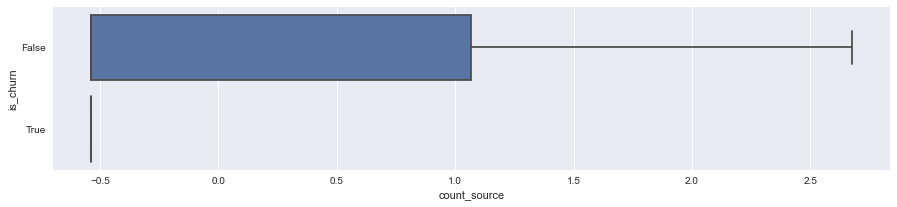

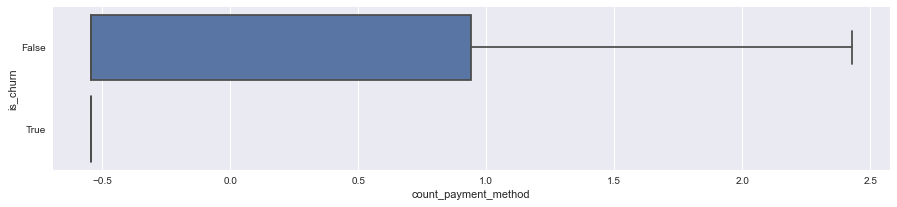

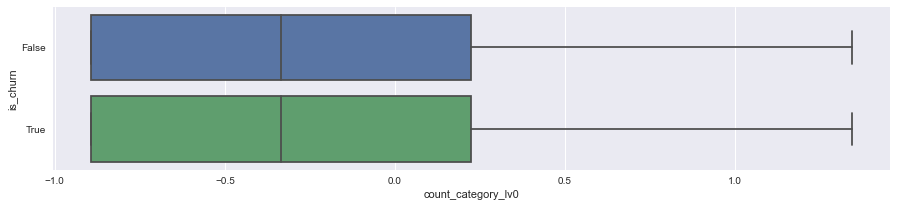

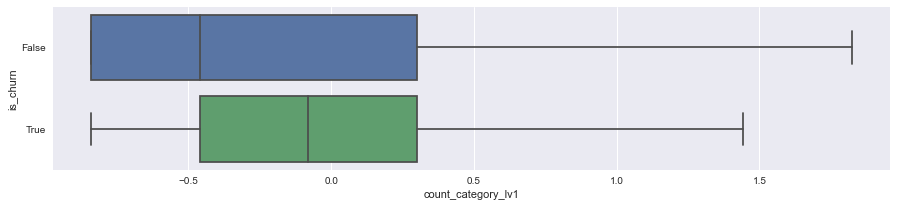

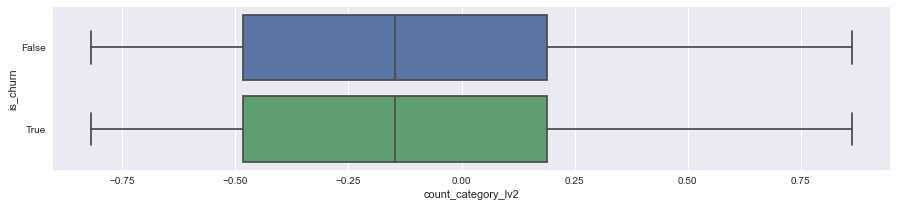

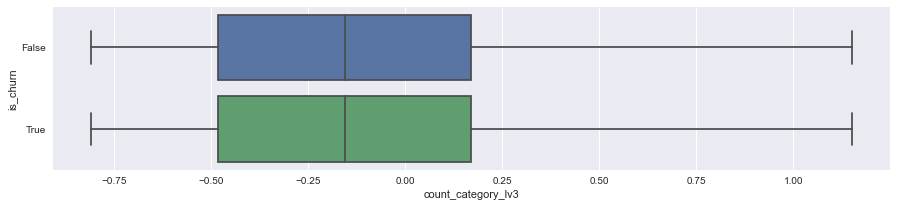

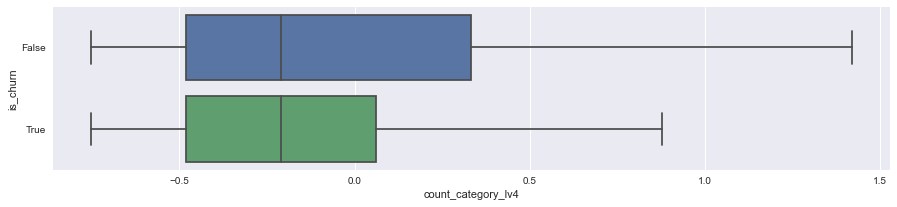

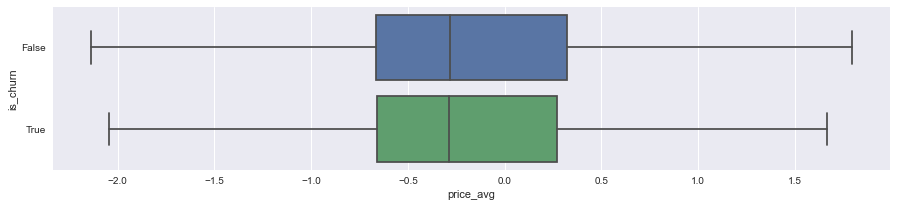

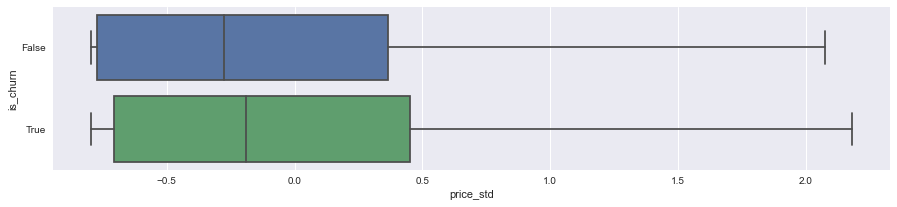

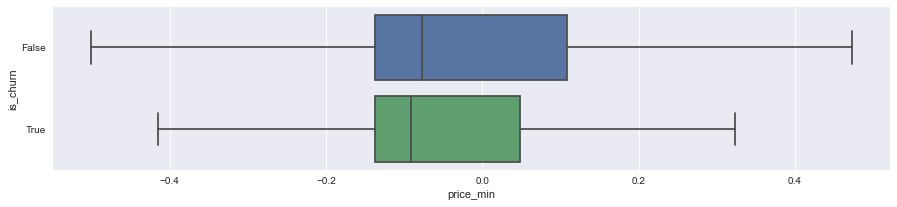

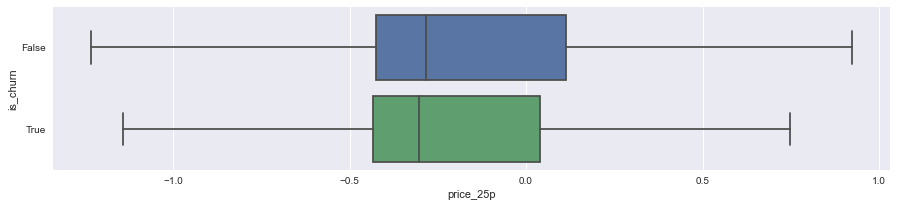

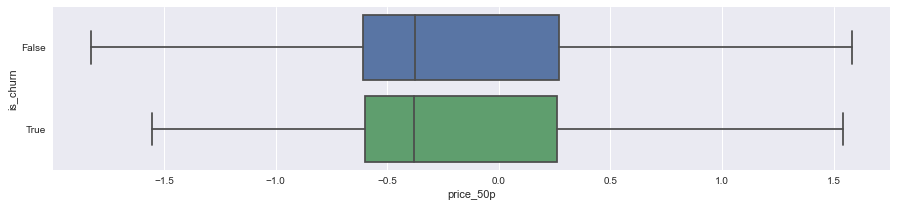

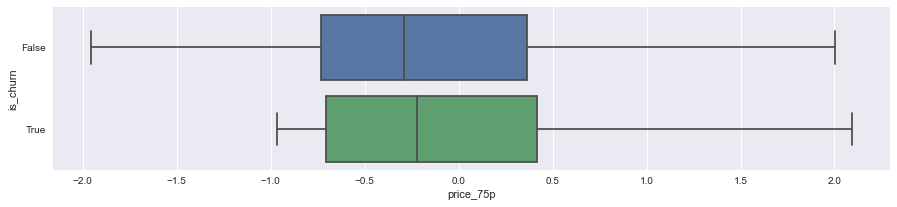

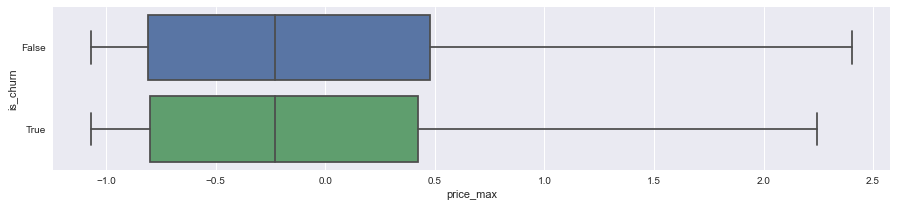

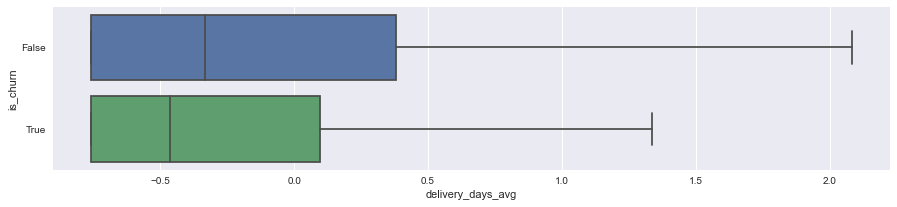

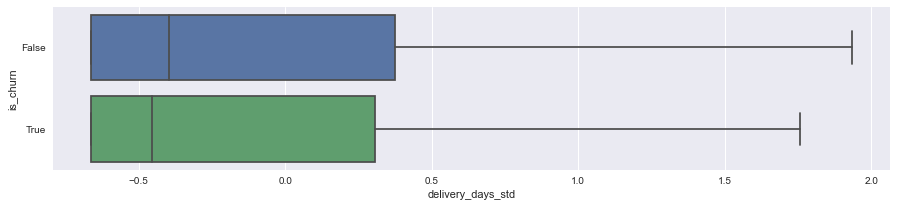

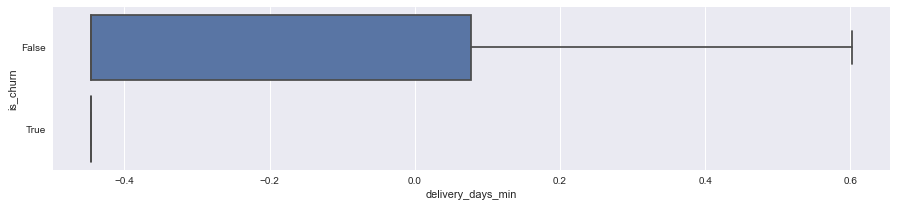

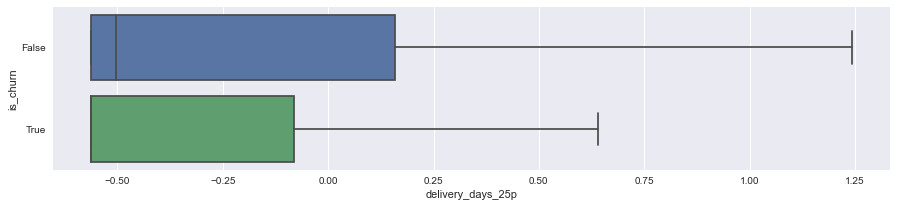

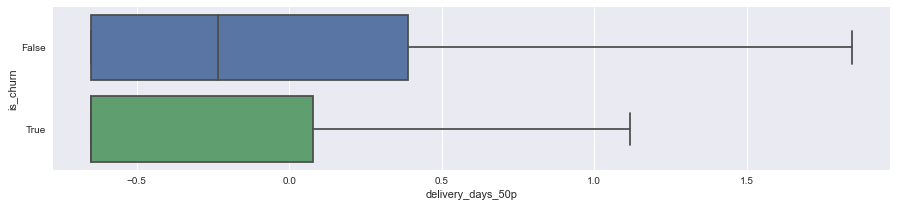

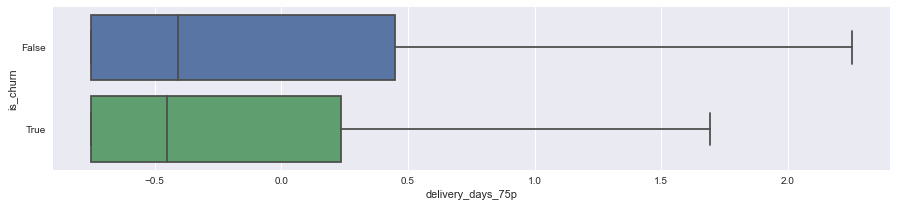

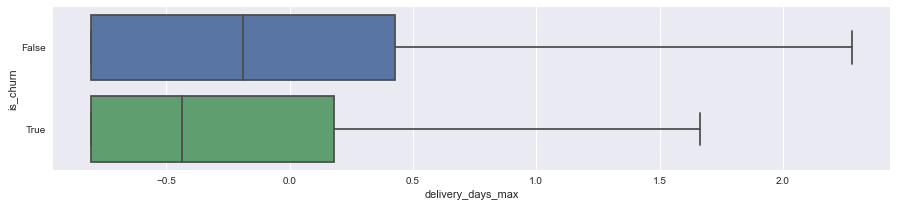

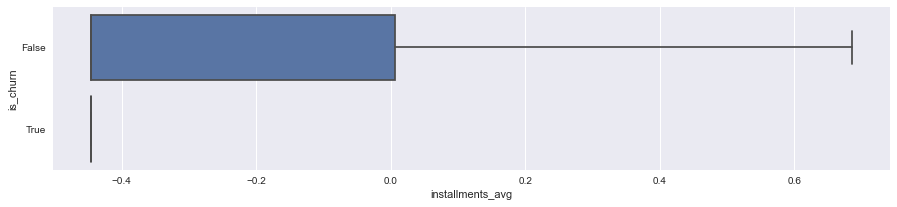

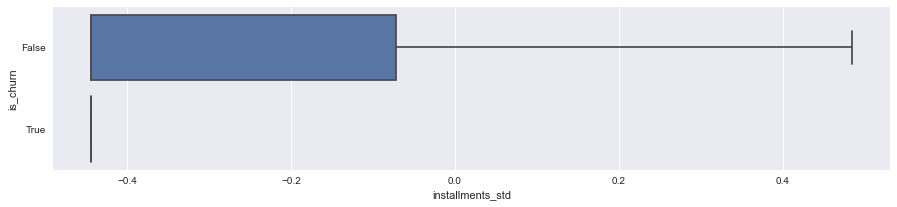

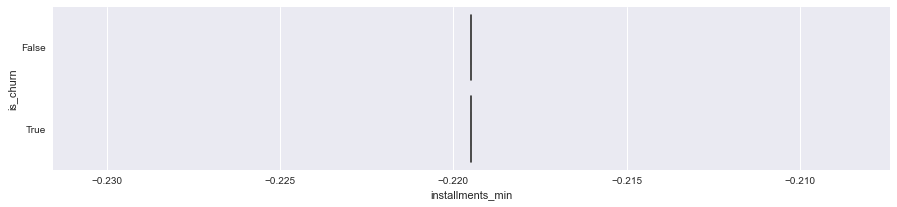

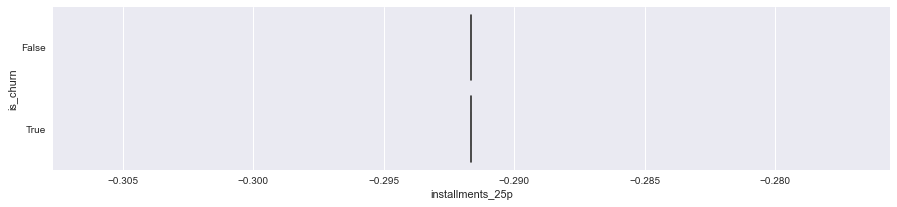

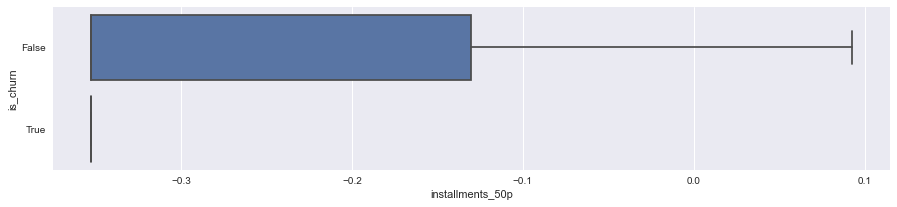

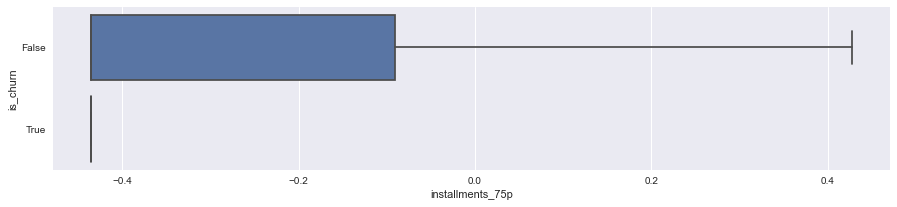

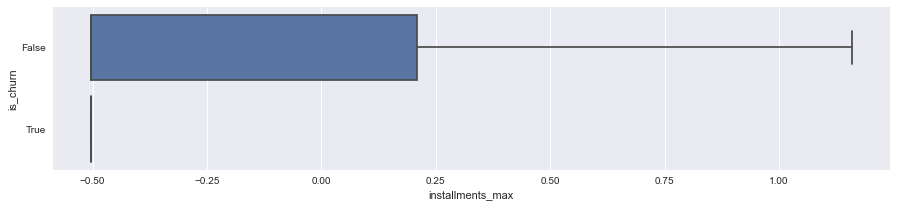

In [87]:
for col in train_dataset.columns[1:-1]:
    plt.figure(figsize=(15, 3))
    sns.boxplot(data=train_dataset, x=col, y="is_churn", orient='h',showfliers=False)
    plt.show()

## 8. Modelagem <a name="modelagem"></a>

In [88]:
X_train = train_dataset.drop('is_churn', axis=1)
y_train = train_dataset['is_churn']
X_test = test_dataset.drop('is_churn', axis=1) 
y_test = test_dataset['is_churn']

#### Funções úteis

In [89]:
def calculate_far_frr (y_proba, y_true, n_points =100, normalize =True, threshold =None):
    """ Função que calcula os dados para a visualização FAR/FRR.

    Parameters
    ----------
    y_true: Series
        Saída esperada (targets).

    y_prob: Series
        Saída probabilística estimada pelo modelo.

    n_points: int (default=100)
        Resolução (quantidade de pontos gerados) do plot.

    normalize: bool (default=True)
        Escolha entre calcular sobre a saída bruta (quantidade de elementos por corte) ou 
        normalizada (percentual de cada dataset).
        
    threshold: float  (default=None)
        Corte usado para a decisão do classificador (predict_proba -> predict).

    Return
    ------

    float
        Corte ótimo (calculado quando `threshold` for None)
    Plot
        Gráfico do FAR/FRR

    """
    
    thr = np.linspace( 0, 1, n_points)
    far = []
    frr = []
    
    for t in thr:
        far_pt = y_proba[y_true == 0][:,1] >= t
        frr_pt = y_proba[y_true == 1][:,1] < t
        if normalize:
            far.append(far_pt.mean())
            frr.append(frr_pt.mean())
        else:
            far.append(far_pt.sum())
            frr.append(frr_pt.sum())
    if threshold is None:
        far = np.array(far)
        frr = np.array(frr)
        optm = thr[ abs(far - frr).argmin()]
    else:
        optm = threshold
    
    plot_data = pd.DataFrame(
        index=thr,
        data={
            'far': far,
            'frr': frr},
        dtype = float)
    
    plt.figure()
   #sns.lineplot(data = plot_data, x=thr, y='far')
    #sns.lineplot(data = plot_data, x=thr, y='frr')
    plot_data['far'].plot(ax=plt.gca(), c='red')
    plot_data['frr'].plot(ax=plt.gca(), c='blue')
    plt.title('FAR / FRR')
    plt.xlabel('Threshold')
    plt.ylabel('Mispredicted')
    plt.axvline(x = optm, color = 'r', linestyle = '--', label=f'decisão (threshold >= {optm*100:5.2f}%)')
    plt.legend()    
    
    return optm

In [90]:
def metricas_classificação(model_name, model, X_te=X_test, y_te=y_test, X_tr=X_train, y_tr=y_train):
    """ Função que calcula as métricas do modelo de classificação.

    Parameters
    ----------
    model_name: String
        Nome do modelo sendo avaliado.
        
    model: Model
        Modelo já fitado sendo avaliado.
    
    X_te: DataFrame (default=X_test)
        Dataframe de teste.
    
    y_te: Series (default=y_test)
        Saída esperada (targets).

    X_tr: DataFrame (default=X_train)
        Dataframe de treino.
    
    y_tr: Series (default=y_train)
        Saída dos dados de treino (targets).

    Return
    ------

    float
        'threshold': Corte ótimo (calculado quando `threshold` for None)
    DataFrame
        'metricas': Métricas de treino e de teste do modelo avaliado
    Plot
        Gráfico do FAR/FRR

    """
    print("Model: {}\n".format(model_name))
    
    y_proba_test = model.predict_proba(X_te)
    y_proba_train = model.predict_proba(X_tr)
    
    threshold = calculate_far_frr (y_proba_train, y_tr, n_points =100, normalize =True, threshold =None)
    
    y_pred_train = (y_proba_train[:,1] >= threshold).astype(int)
    y_pred_test = (y_proba_test[:,1] >= threshold).astype(int)
    
    accuracy_train =  round(accuracy_score(y_tr, y_pred_train), 4)
    precision_train = round(precision_score(y_tr, y_pred_train), 4)
    recall_train =  round(recall_score(y_tr, y_pred_train), 4)
    f1_train = round(f1_score(y_tr, y_pred_train), 4)
    auc_train = round(roc_auc_score(y_tr, y_pred_train), 4)
    
    train_confusion_matrix = confusion_matrix(y_tr,y_pred_train)
    TN_train = train_confusion_matrix[0][0]
    FP_train = train_confusion_matrix[0][1]
    FN_train = train_confusion_matrix[1][0]
    TP_train = train_confusion_matrix[1][1]
    
    accuracy =  round(accuracy_score(y_te, y_pred_test), 4)
    precision = round(precision_score(y_te, y_pred_test), 4)
    recall =  round(recall_score(y_te, y_pred_test), 4)
    f1 = round(f1_score(y_te, y_pred_test), 4)
    auc = round(roc_auc_score(y_te, y_pred_test), 4)
    
    test_confusion_matrix = confusion_matrix(y_te,y_pred_test)
    TN = test_confusion_matrix[0][0]
    FP = test_confusion_matrix[0][1]
    FN = test_confusion_matrix[1][0]
    TP = test_confusion_matrix[1][1]
    
    metricas = pd.DataFrame({'TN':[TN_train, TN], 
                             'FP':[FP_train, FP],
                             'FN':[FN_train, FN], 
                             'TP':[TP_train, TP], 
                             'Accuracy':[accuracy_train, accuracy],
                             'Precision':[precision_train, precision], 
                             'Recall':[recall_train, recall], 
                             'F1 Score':[f1_train, f1],
                             'AUC':[auc_train, auc]}, 
                            index=[model_name+' Train', model_name])

    print('Treino:')
    print('\nConfusion Matrix') 
    print(train_confusion_matrix)
    print('\n')
    print(classification_report(y_tr,y_pred_train))
    print('\n')
    print('Teste:')
    print('\nConfusion Matrix') 
    print(test_confusion_matrix)
    print('\n')
    print(classification_report(y_te,y_pred_test))
    
    return threshold, y_pred_test, metricas

## Baseline

Definiremos um baseline utilizando uma Decision Tree para verificar a performance em Treino e Teste.

In [91]:
dtc_baseline = DecisionTreeClassifier(random_state=42, class_weight='balanced')

In [92]:
dtc_baseline.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

Model: Baseline

Treino:

Confusion Matrix
[[19054    31]
 [    4  4203]]


              precision    recall  f1-score   support

       False       1.00      1.00      1.00     19085
        True       0.99      1.00      1.00      4207

    accuracy                           1.00     23292
   macro avg       1.00      1.00      1.00     23292
weighted avg       1.00      1.00      1.00     23292



Teste:

Confusion Matrix
[[5203 1165]
 [1103  293]]


              precision    recall  f1-score   support

       False       0.83      0.82      0.82      6368
        True       0.20      0.21      0.21      1396

    accuracy                           0.71      7764
   macro avg       0.51      0.51      0.51      7764
weighted avg       0.71      0.71      0.71      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Baseline Train,19054,31,4,4203,0.9985,0.9927,0.9990,0.9959,0.9987
Baseline,5203,1165,1103,293,0.7079,0.2010,0.2099,0.2053,0.5135


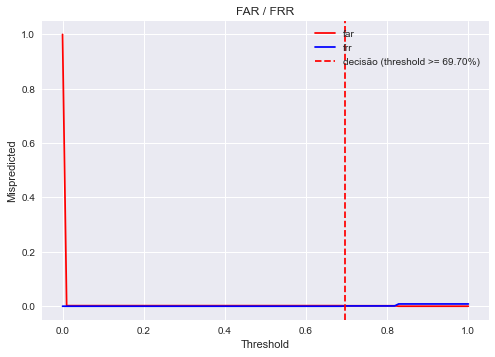

In [93]:
baseline_threshold, y_pred_baseline, baseline_metricas = metricas_classificação('Baseline', dtc_baseline)
baseline_metricas

## Logistic Regression

In [94]:
lr = LogisticRegression(random_state=42, solver = 'liblinear', class_weight='balanced')

In [95]:
param_lr = {'penalty' : ['l1', 'l2'],
            'C' : np.logspace(-4, 4, 20)}

gs_lr = RandomizedSearchCV(lr, param_lr, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_lr.fit(X_train, y_train)
print(gs_lr.best_params_)
print(gs_lr.best_score_)

{'penalty': 'l2', 'C': 0.004832930238571752}
0.3459297915193712


In [96]:
lr = LogisticRegression(random_state=42, 
                            solver = 'liblinear',
                            penalty = gs_lr.best_params_['penalty'],
                            C = gs_lr.best_params_['C'],
                            class_weight='balanced')

lr.fit(X_train, y_train)

LogisticRegression(C=0.004832930238571752, class_weight='balanced',
                   random_state=42, solver='liblinear')

Model: LogisticRegression

Treino:

Confusion Matrix
[[11647  7438]
 [ 1812  2395]]


              precision    recall  f1-score   support

       False       0.87      0.61      0.72     19085
        True       0.24      0.57      0.34      4207

    accuracy                           0.60     23292
   macro avg       0.55      0.59      0.53     23292
weighted avg       0.75      0.60      0.65     23292



Teste:

Confusion Matrix
[[3874 2494]
 [ 641  755]]


              precision    recall  f1-score   support

       False       0.86      0.61      0.71      6368
        True       0.23      0.54      0.33      1396

    accuracy                           0.60      7764
   macro avg       0.55      0.57      0.52      7764
weighted avg       0.75      0.60      0.64      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
LogisticRegression Train,11647,7438,1812,2395,0.6029,0.2436,0.5693,0.3412,0.5898
LogisticRegression,3874,2494,641,755,0.5962,0.2324,0.5408,0.3251,0.5746


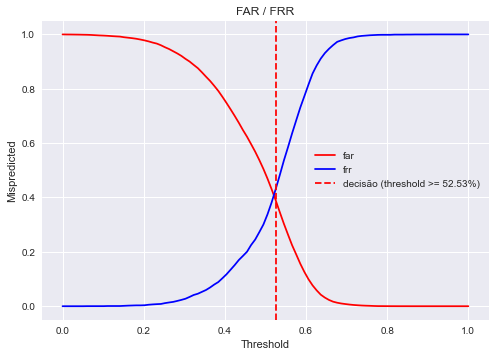

In [97]:
lr_threshold, y_pred_lr, lr_metricas = metricas_classificação('LogisticRegression', lr)
lr_metricas

## Random Forest

In [98]:
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

In [99]:
param_rfc = {'n_estimators' : [50, 100, 250, 500],
             'max_depth': [5, 10, 15, 20, 25],
             'min_samples_leaf' : [2, 5, 7, 10], 
             'min_samples_split':[2, 5, 7, 10, 15],
             'max_features' : ['sqrt', 0.1,  0.2, 0.3, 0.4, 0.5], 
             'oob_score': [True]}

gs_rfc = RandomizedSearchCV(rfc, param_rfc, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_rfc.fit(X_train, y_train)
print(gs_rfc.best_params_)
print(gs_rfc.best_score_)

{'oob_score': True, 'n_estimators': 250, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.4, 'max_depth': 5}
0.3524662252333991


In [100]:
rfc = RandomForestClassifier(random_state=42, 
                             n_estimators = gs_rfc.best_params_['n_estimators'],
                             max_depth = gs_rfc.best_params_['max_depth'], 
                             min_samples_leaf = gs_rfc.best_params_['min_samples_leaf'], 
                             min_samples_split = gs_rfc.best_params_['min_samples_split'], 
                             max_features = gs_rfc.best_params_['max_features'], 
                             oob_score =  gs_rfc.best_params_['oob_score'], 
                             class_weight='balanced')

rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.4,
                       min_samples_leaf=2, min_samples_split=7,
                       n_estimators=250, oob_score=True, random_state=42)

Model: RandomForest

Treino:

Confusion Matrix
[[11762  7323]
 [ 1611  2596]]


              precision    recall  f1-score   support

       False       0.88      0.62      0.72     19085
        True       0.26      0.62      0.37      4207

    accuracy                           0.62     23292
   macro avg       0.57      0.62      0.55     23292
weighted avg       0.77      0.62      0.66     23292



Teste:

Confusion Matrix
[[3849 2519]
 [ 578  818]]


              precision    recall  f1-score   support

       False       0.87      0.60      0.71      6368
        True       0.25      0.59      0.35      1396

    accuracy                           0.60      7764
   macro avg       0.56      0.60      0.53      7764
weighted avg       0.76      0.60      0.65      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
RandomForest Train,11762,7323,1611,2596,0.6164,0.2617,0.6171,0.3675,0.6167
RandomForest,3849,2519,578,818,0.6011,0.2451,0.5860,0.3457,0.5952


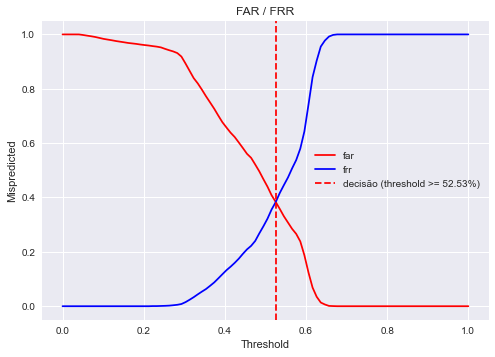

In [101]:
rfc_threshold, y_pred_rfc, rfc_metricas = metricas_classificação('RandomForest', rfc)
rfc_metricas

## SVC

In [102]:
#svc = SVC(random_state=42, probability=True, class_weight='balanced')

In [103]:
'''param_svc = {'C': [0.1, 1, 10, 100, 1000],
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}


gs_svc = RandomizedSearchCV(svc, param_svc, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_svc.fit(X_train, y_train)
print(gs_svc.best_params_)
print(gs_svc.best_score_)'''

"param_svc = {'C': [0.1, 1, 10, 100, 1000],\n             'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}\n\n\ngs_svc = RandomizedSearchCV(svc, param_svc, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)\ngs_svc.fit(X_train, y_train)\nprint(gs_svc.best_params_)\nprint(gs_svc.best_score_)"

In [104]:
svc = SVC(random_state=42, 
          probability=True, 
          C=0.0001, #gs_svc.best_params_['C'], 
          gamma=1000,#gs_svc.best_params_['gamma'], 
          class_weight='balanced')

svc.fit(X_train, y_train)

SVC(C=0.0001, class_weight='balanced', gamma=1000, probability=True,
    random_state=42)

Model: SVC

Treino:

Confusion Matrix
[[    0 19085]
 [    0  4207]]


              precision    recall  f1-score   support

       False       0.00      0.00      0.00     19085
        True       0.18      1.00      0.31      4207

    accuracy                           0.18     23292
   macro avg       0.09      0.50      0.15     23292
weighted avg       0.03      0.18      0.06     23292



Teste:

Confusion Matrix
[[   0 6368]
 [   0 1396]]


              precision    recall  f1-score   support

       False       0.00      0.00      0.00      6368
        True       0.18      1.00      0.30      1396

    accuracy                           0.18      7764
   macro avg       0.09      0.50      0.15      7764
weighted avg       0.03      0.18      0.05      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
SVC Train,0,19085,0,4207,0.1806,0.1806,1.0,0.3060,0.5
SVC,0,6368,0,1396,0.1798,0.1798,1.0,0.3048,0.5


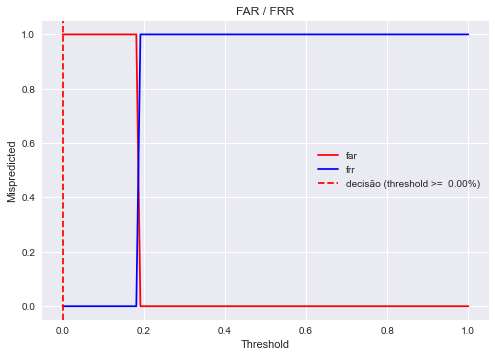

In [105]:
svc_threshold, y_pred_svc, svc_metricas = metricas_classificação('SVC', svc)
svc_metricas

## KNN

In [106]:
knn = KNeighborsClassifier()

In [107]:
param_knn = {'n_neighbors':[3, 5, 6, 9, 15],
             'leaf_size':[2, 5, 8, 11],
             'p': [1, 2, 4, 6, 8, 10]}

gs_knn = RandomizedSearchCV(knn, param_knn, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_knn.fit(X_train, y_train)
print(gs_knn.best_params_)
print(gs_knn.best_score_)

{'p': 1, 'n_neighbors': 3, 'leaf_size': 2}
0.16106411153147882


In [108]:
knn = KNeighborsClassifier(n_neighbors= gs_knn.best_params_['n_neighbors'], 
                           leaf_size= gs_knn.best_params_['leaf_size'], 
                           p= gs_knn.best_params_['p'])

knn.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=2, n_neighbors=3, p=1)

Model: KNN

Treino:

Confusion Matrix
[[13274  5811]
 [    0  4207]]


              precision    recall  f1-score   support

       False       1.00      0.70      0.82     19085
        True       0.42      1.00      0.59      4207

    accuracy                           0.75     23292
   macro avg       0.71      0.85      0.71     23292
weighted avg       0.90      0.75      0.78     23292



Teste:

Confusion Matrix
[[3724 2644]
 [ 738  658]]


              precision    recall  f1-score   support

       False       0.83      0.58      0.69      6368
        True       0.20      0.47      0.28      1396

    accuracy                           0.56      7764
   macro avg       0.52      0.53      0.48      7764
weighted avg       0.72      0.56      0.61      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
KNN Train,13274,5811,0,4207,0.7505,0.4199,1.0000,0.5915,0.8478
KNN,3724,2644,738,658,0.5644,0.1993,0.4713,0.2801,0.5281


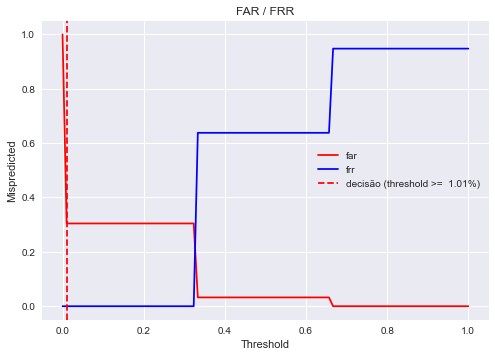

In [109]:
knn_threshold, y_pred_knn, knn_metricas = metricas_classificação('KNN', knn)
knn_metricas

## GaussianNB

In [110]:
nb = GaussianNB()

In [111]:
param_nb = {'var_smoothing': np.linspace(1e-15, 1e-2, num=10000)}

gs_nb = RandomizedSearchCV(nb, param_nb, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_nb.fit(X_train, y_train)
print(gs_nb.best_params_)
print(gs_nb.best_score_)

{'var_smoothing': 0.0033853385338540472}
0.32873842724505653


In [112]:
nb = GaussianNB(var_smoothing=gs_nb.best_params_['var_smoothing'])

nb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.0033853385338540472)

Model: GaussianNB

Treino:

Confusion Matrix
[[10809  8276]
 [ 1729  2478]]


              precision    recall  f1-score   support

       False       0.86      0.57      0.68     19085
        True       0.23      0.59      0.33      4207

    accuracy                           0.57     23292
   macro avg       0.55      0.58      0.51     23292
weighted avg       0.75      0.57      0.62     23292



Teste:

Confusion Matrix
[[3561 2807]
 [ 591  805]]


              precision    recall  f1-score   support

       False       0.86      0.56      0.68      6368
        True       0.22      0.58      0.32      1396

    accuracy                           0.56      7764
   macro avg       0.54      0.57      0.50      7764
weighted avg       0.74      0.56      0.61      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
GaussianNB Train,10809,8276,1729,2478,0.5705,0.2304,0.5890,0.3313,0.5777
GaussianNB,3561,2807,591,805,0.5623,0.2229,0.5766,0.3215,0.5679


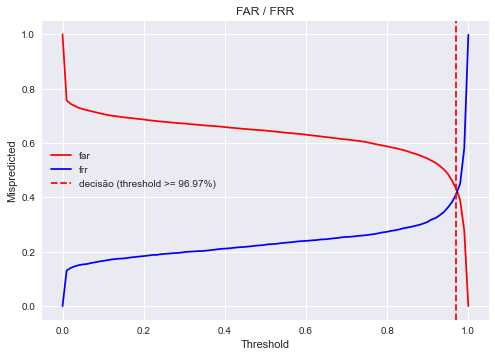

In [113]:
nb_threshold, y_pred_nb, nb_metricas = metricas_classificação('GaussianNB', nb)
nb_metricas

## Bagging

In [114]:
bag = BaggingClassifier(random_state=42, n_jobs=-1)

In [115]:
param_bag = {'n_estimators':[10, 20, 50, 100, 200]}


gs_bag = GridSearchCV(bag, param_bag, cv=5, n_jobs=-1, scoring='f1')
gs_bag.fit(X_train, y_train)
print(gs_bag.best_params_)
print(gs_bag.best_score_)

{'n_estimators': 10}
0.09112471578782888


In [116]:
bag = BaggingClassifier(random_state=42, bootstrap=True, n_jobs=-1,
                        n_estimators=gs_bag.best_params_['n_estimators'])

bag.fit(X_train, y_train)

BaggingClassifier(n_jobs=-1, random_state=42)

Model: Bagging

Treino:

Confusion Matrix
[[18841   244]
 [   53  4154]]


              precision    recall  f1-score   support

       False       1.00      0.99      0.99     19085
        True       0.94      0.99      0.97      4207

    accuracy                           0.99     23292
   macro avg       0.97      0.99      0.98     23292
weighted avg       0.99      0.99      0.99     23292



Teste:

Confusion Matrix
[[5263 1105]
 [1096  300]]


              precision    recall  f1-score   support

       False       0.83      0.83      0.83      6368
        True       0.21      0.21      0.21      1396

    accuracy                           0.72      7764
   macro avg       0.52      0.52      0.52      7764
weighted avg       0.72      0.72      0.72      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Bagging Train,18841,244,53,4154,0.9872,0.9445,0.9874,0.9655,0.9873
Bagging,5263,1105,1096,300,0.7165,0.2135,0.2149,0.2142,0.5207


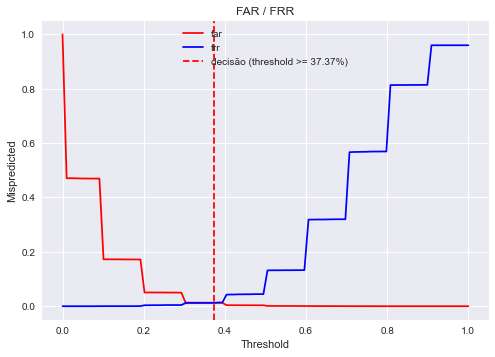

In [117]:
bag_threshold, y_pred_bag, bag_metricas = metricas_classificação('Bagging', bag)
bag_metricas

## AdaBoost

In [118]:
ada = AdaBoostClassifier(random_state=42)

In [119]:
param_ada = {'n_estimators':[50, 75, 100], 
             'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5, 1]}


gs_ada = GridSearchCV(ada, param_ada, cv=5, n_jobs=-1, scoring='f1')
gs_ada.fit(X_train, y_train)
print(gs_ada.best_params_)
print(gs_ada.best_score_)

{'learning_rate': 1, 'n_estimators': 100}
0.011920577623375657


In [120]:
ada = AdaBoostClassifier(random_state=42, 
                         n_estimators= gs_ada.best_params_['n_estimators'], 
                         learning_rate= gs_ada.best_params_['learning_rate'])
ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)

Model: AdaBoost

Treino:

Confusion Matrix
[[ 5395 13690]
 [  426  3781]]


              precision    recall  f1-score   support

       False       0.93      0.28      0.43     19085
        True       0.22      0.90      0.35      4207

    accuracy                           0.39     23292
   macro avg       0.57      0.59      0.39     23292
weighted avg       0.80      0.39      0.42     23292



Teste:

Confusion Matrix
[[1724 4644]
 [ 186 1210]]


              precision    recall  f1-score   support

       False       0.90      0.27      0.42      6368
        True       0.21      0.87      0.33      1396

    accuracy                           0.38      7764
   macro avg       0.55      0.57      0.38      7764
weighted avg       0.78      0.38      0.40      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
AdaBoost Train,5395,13690,426,3781,0.3940,0.2164,0.8987,0.3488,0.5907
AdaBoost,1724,4644,186,1210,0.3779,0.2067,0.8668,0.3338,0.5687


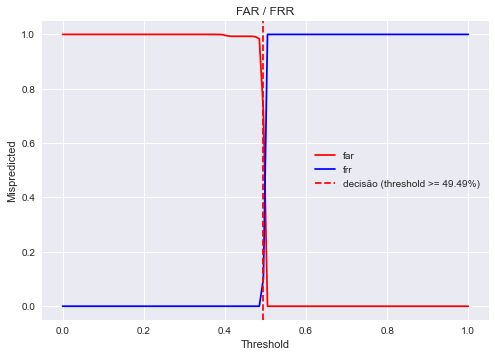

In [121]:
ada_threshold, y_pred_ada, ada_metricas = metricas_classificação('AdaBoost', ada)
ada_metricas

## Gradient Boosting

In [122]:
gbc = GradientBoostingClassifier(random_state=42)

In [123]:
param_gbc = {'learning_rate':np.linspace(0.01, 1, 50), 
             'n_estimators':[100, 200, 500, 1000], 
             'subsample':[0.2, 0.3, 0.4, 0.5, 0.7], 
             'max_depth':[1, 2, 3, 5, 7], 
             'max_features':['sqrt', 0.2, 0.4, 0.5]}


param_gbc = RandomizedSearchCV(gbc, param_gbc, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
param_gbc.fit(X_train, y_train)
print(param_gbc.best_params_)
print(param_gbc.best_score_)

{'subsample': 0.2, 'n_estimators': 1000, 'max_features': 0.2, 'max_depth': 3, 'learning_rate': 0.7979591836734694}
0.24910699858673208


In [124]:
gbc = GradientBoostingClassifier(random_state=42, 
                                 learning_rate=param_gbc.best_params_['learning_rate'], 
                                 n_estimators=param_gbc.best_params_['n_estimators'], 
                                 subsample=param_gbc.best_params_['subsample'], 
                                 max_depth=param_gbc.best_params_['max_depth'], 
                                 max_features=param_gbc.best_params_['max_features'])
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.7979591836734694, max_features=0.2,
                           n_estimators=1000, random_state=42, subsample=0.2)

Model: GradientBoosting

Treino:

Confusion Matrix
[[14005  5080]
 [ 3055  1152]]


              precision    recall  f1-score   support

       False       0.82      0.73      0.77     19085
        True       0.18      0.27      0.22      4207

    accuracy                           0.65     23292
   macro avg       0.50      0.50      0.50     23292
weighted avg       0.71      0.65      0.67     23292



Teste:

Confusion Matrix
[[4674 1694]
 [1041  355]]


              precision    recall  f1-score   support

       False       0.82      0.73      0.77      6368
        True       0.17      0.25      0.21      1396

    accuracy                           0.65      7764
   macro avg       0.50      0.49      0.49      7764
weighted avg       0.70      0.65      0.67      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
GradientBoosting Train,14005,5080,3055,1152,0.6507,0.1849,0.2738,0.2207,0.5038
GradientBoosting,4674,1694,1041,355,0.6477,0.1733,0.2543,0.2061,0.4941


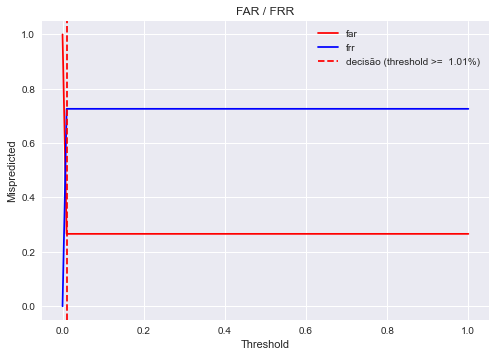

In [125]:
gbc_threshold, y_pred_gbc, gbc_metricas = metricas_classificação('GradientBoosting', gbc)
gbc_metricas

## LGBM

In [126]:
lgbm = LGBMClassifier(objective='binary',random_state=42, class_weight='balanced')

In [127]:
param_lgbm = {'num_leaves':[30, 50, 100, 150], 
              'max_depth':[5, 7, 10, 15],
              'learning_rate':np.linspace(0.01, 0.5, 50),
              'n_estimators':[100, 200, 500, 1000]}

gs_lgbm = RandomizedSearchCV(lgbm, param_lgbm, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_lgbm.fit(X_train, y_train)
print(gs_lgbm.best_params_)
print(gs_lgbm.best_score_)

{'num_leaves': 100, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03}
0.3558299301159805


In [128]:
lgbm = LGBMClassifier(objective='binary',
                       random_state=42,
                       num_leaves = gs_lgbm.best_params_['num_leaves'], 
                       max_depth = gs_lgbm.best_params_['max_depth'], 
                       learning_rate = gs_lgbm.best_params_['learning_rate'], 
                       n_estimators = gs_lgbm.best_params_['n_estimators'], class_weight='balanced')
lgbm.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.03, max_depth=5,
               num_leaves=100, objective='binary', random_state=42)

Model: LGBM

Treino:

Confusion Matrix
[[11971  7114]
 [ 1460  2747]]


              precision    recall  f1-score   support

       False       0.89      0.63      0.74     19085
        True       0.28      0.65      0.39      4207

    accuracy                           0.63     23292
   macro avg       0.58      0.64      0.56     23292
weighted avg       0.78      0.63      0.67     23292



Teste:

Confusion Matrix
[[3867 2501]
 [ 580  816]]


              precision    recall  f1-score   support

       False       0.87      0.61      0.72      6368
        True       0.25      0.58      0.35      1396

    accuracy                           0.60      7764
   macro avg       0.56      0.60      0.53      7764
weighted avg       0.76      0.60      0.65      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
LGBM Train,11971,7114,1460,2747,0.6319,0.2786,0.6530,0.3905,0.6401
LGBM,3867,2501,580,816,0.6032,0.2460,0.5845,0.3463,0.5959


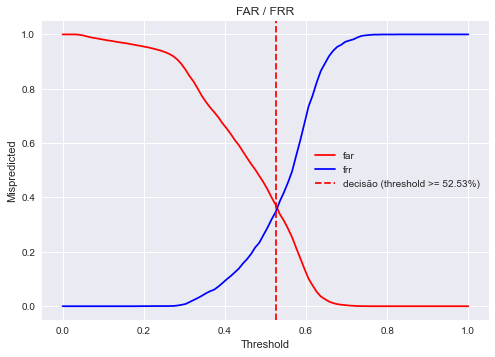

In [129]:
lgbm_threshold, y_pred_lgbm, lgbm_metricas = metricas_classificação('LGBM', lgbm)
lgbm_metricas

## XGBoost

In [130]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42, eval_metric = 'logloss')

In [131]:
param_xgb = {'max_depth':[3, 5, 7, 10, 15],
             'learning_rate':np.linspace(0.01, 0.7, 50),
             'n_estimators':[100, 500, 1000, 2000],
             'eta': np.linspace(0.1, 1, 50), 
             'colsample_bytree':np.linspace(0.1, 0.7, 50)}

gs_xgb = RandomizedSearchCV(xgb, param_xgb, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_xgb.fit(X_train, y_train)
print(gs_xgb.best_params_)
print(gs_xgb.best_score_)

{'n_estimators': 2000, 'max_depth': 7, 'learning_rate': 0.643673469387755, 'eta': 0.8163265306122449, 'colsample_bytree': 0.3938775510204081}
0.15840159172728835


In [132]:
xgb = XGBClassifier(objective='binary:logistic', 
                    random_state=42, 
                    eval_metric = 'logloss', 
                    max_depth = gs_xgb.best_params_['max_depth'],
                    learning_rate = gs_xgb.best_params_['learning_rate'], 
                    n_estimators = gs_xgb.best_params_['n_estimators'],
                    eta = gs_xgb.best_params_['eta'], 
                    colsample_bytree = gs_xgb.best_params_['colsample_bytree'])
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3938775510204081,
              enable_categorical=False, eta=0.8163265306122449,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.643673469387755,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Model: XGBoost

Treino:

Confusion Matrix
[[19055    30]
 [    6  4201]]


              precision    recall  f1-score   support

       False       1.00      1.00      1.00     19085
        True       0.99      1.00      1.00      4207

    accuracy                           1.00     23292
   macro avg       1.00      1.00      1.00     23292
weighted avg       1.00      1.00      1.00     23292



Teste:

Confusion Matrix
[[5755  613]
 [1221  175]]


              precision    recall  f1-score   support

       False       0.82      0.90      0.86      6368
        True       0.22      0.13      0.16      1396

    accuracy                           0.76      7764
   macro avg       0.52      0.51      0.51      7764
weighted avg       0.72      0.76      0.74      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
XGBoost Train,19055,30,6,4201,0.9985,0.9929,0.9986,0.9957,0.9985
XGBoost,5755,613,1221,175,0.7638,0.2221,0.1254,0.1603,0.5145


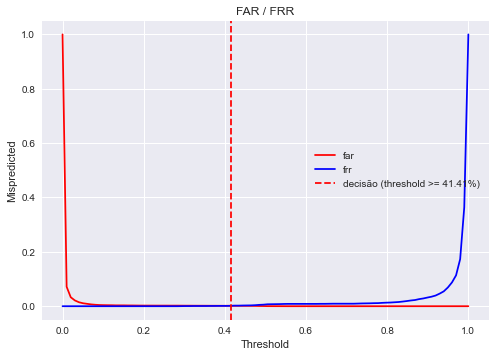

In [133]:
xgb_threshold, y_pred_xgb, xgb_metricas = metricas_classificação('XGBoost', xgb)
xgb_metricas

## Métricas

In [134]:
metrics = pd.concat([baseline_metricas, lr_metricas, rfc_metricas, svc_metricas, knn_metricas, nb_metricas, bag_metricas, 
                     ada_metricas, gbc_metricas, lgbm_metricas, xgb_metricas])

In [135]:
metrics

,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Baseline Train,19054,31,4,4203,0.9985,0.9927,0.9990,0.9959,0.9987
Baseline,5203,1165,1103,293,0.7079,0.2010,0.2099,0.2053,0.5135
LogisticRegression Train,11647,7438,1812,2395,0.6029,0.2436,0.5693,0.3412,0.5898
LogisticRegression,3874,2494,641,755,0.5962,0.2324,0.5408,0.3251,0.5746
RandomForest Train,11762,7323,1611,2596,0.6164,0.2617,0.6171,0.3675,0.6167
RandomForest,3849,2519,578,818,0.6011,0.2451,0.5860,0.3457,0.5952
SVC Train,0,19085,0,4207,0.1806,0.1806,1.0000,0.3060,0.5000
SVC,0,6368,0,1396,0.1798,0.1798,1.0000,0.3048,0.5000
KNN Train,13274,5811,0,4207,0.7505,0.4199,1.0000,0.5915,0.8478
KNN,3724,2644,738,658,0.5644,0.1993,0.4713,0.2801,0.5281


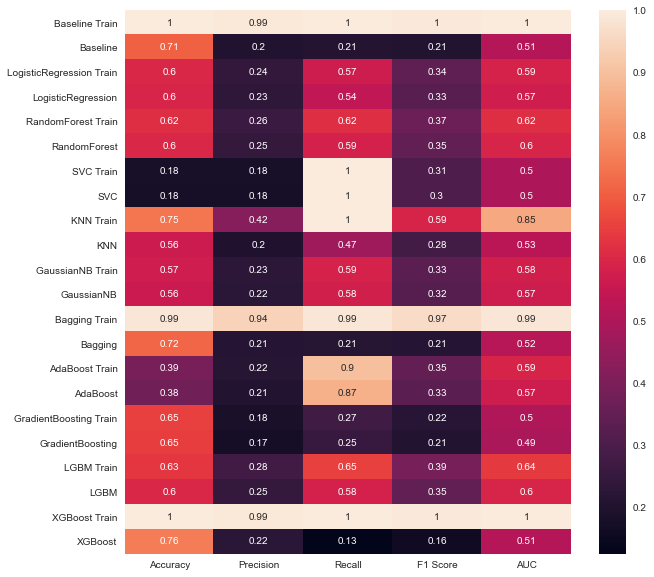

In [136]:
plt.figure(figsize=(10,10))
sns.heatmap(metrics.iloc[:,4:], annot=True)
plt.show()

Com base nesta comparação, os modelos Baseline, KNN, Bagging e XGBoost overfitaram.<br>

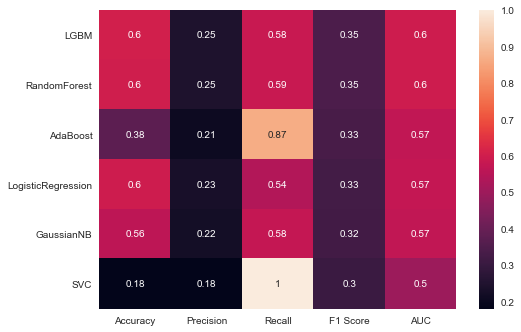

In [137]:
sns.heatmap(metrics.loc[['LogisticRegression', 'RandomForest', 'SVC', 'GaussianNB', 'AdaBoost', 'LGBM'],
                        ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']].sort_values('F1 Score', ascending=False),
            annot=True)
plt.show()

A melhor performance independente obtida foi do LGBM, seguido por RandomForest, AdaBoost e LogisticRegression.

## 8. Ensembles <a name="ensembles"></a>

## Avaliando combinações

Avaliaremos possíveis combinações de modelos, para verificar o potencial existente nos modelos.

In [138]:
models_list = [#'Baseline',
    'LogisticRegression',
    'RandomForest', 
    #'SVC', 
    #'KNN',
    #'GaussianNB'
    #'Bagging', 
    'AdaBoost', 
    #'GradientBoosting', 
    'LGBM' 
    #'XGB'
]

In [139]:
potencial_ensemble = pd.DataFrame({'Target': y_test,
                                  #'Baseline': y_pred_baseline,
                                   'LogisticRegression':y_pred_lr,
                                  'RandomForest': y_pred_rfc,
                                  #'SVC': y_pred_svc,
                                  #'KNN':y_pred_knn,
                                  #'GaussianNB':y_pred_nb
                                  #'Bagging': y_pred_bag,
                                  'AdaBoost': y_pred_ada,
                                  #'GradientBoosting': y_pred_gbc,
                                  'LGBM': y_pred_lgbm
                                  #'XGB': y_pred_xgb
                                  })

potencial_ensemble = potencial_ensemble.astype(int)

In [140]:
potencial_ensemble

,Target,LogisticRegression,RandomForest,AdaBoost,LGBM
client_id,,,,,
cx06840,0,0,1,1,1
cx01931,0,0,1,1,1
cx35431,0,1,1,1,1
cx36233,0,1,1,1,1
cx13540,0,1,1,1,1
...,...,...,...,...,...
cx19119,0,0,0,1,0
cx21963,0,1,1,1,1
cx37195,0,1,1,1,1


In [141]:
potencial_ensemble['Previsão Ótima'] = np.nan

for col in models_list:
  for i in range(len(potencial_ensemble)):
    if potencial_ensemble['Previsão Ótima'][i] == potencial_ensemble.Target[i]:
        pass
    elif (potencial_ensemble[col][i] == potencial_ensemble.Target[i]) and (potencial_ensemble['Previsão Ótima'][i] != potencial_ensemble.Target[i]):
        potencial_ensemble['Previsão Ótima'][i] = potencial_ensemble[col][i]
    elif (potencial_ensemble[col][i] != potencial_ensemble.Target[i]) and (potencial_ensemble['Previsão Ótima'][i] != potencial_ensemble.Target[i]):
        potencial_ensemble['Previsão Ótima'][i] = potencial_ensemble[col][i]

In [142]:
row = {#'Baseline': f1_score(potencial_ensemble.Target,  potencial_ensemble['Baseline']),
       'LogisticRegression' : f1_score(potencial_ensemble.Target, potencial_ensemble['LogisticRegression']),
       'RandomForest' : f1_score(potencial_ensemble.Target, potencial_ensemble['RandomForest']),
       #'SVC': f1_score(potencial_ensemble.Target, potencial_ensemble['SVC']),
       #'KNN' : f1_score(potencial_ensemble.Target, potencial_ensemble['KNN']),
       #'GaussianNB' : f1_score(potencial_ensemble.Target, potencial_ensemble['GaussianNB']),
       #'Bagging': f1_score(potencial_ensemble.Target, potencial_ensemble['Bagging']),
       'AdaBoost': f1_score(potencial_ensemble.Target, potencial_ensemble['AdaBoost']),
       #'GradientBoosting': f1_score(potencial_ensemble.Target, potencial_ensemble['GradientBoosting']),
       'LGBM': f1_score(potencial_ensemble.Target, potencial_ensemble['LGBM']),
       #'XGB': f1_score(potencial_ensemble.Target, potencial_ensemble['XGB']),
       'Previsão Ótima' : f1_score(potencial_ensemble.Target, potencial_ensemble['Previsão Ótima'])}

In [143]:
potencial_ensemble = potencial_ensemble.append(row, ignore_index=True)

In [144]:
potencial_ensemble

,Target,LogisticRegression,RandomForest,AdaBoost,LGBM,Previsão Ótima
0,0.0,0.000000,1.000000,1.000000,1.000000,0.000000
1,0.0,0.000000,1.000000,1.000000,1.000000,0.000000
2,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...
7760,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
7761,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
7762,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
7763,1.0,0.000000,0.000000,0.000000,0.000000,0.000000


## Voting

In [145]:
voting = VotingClassifier(estimators=[#('Baseline', dtc_baseline), 
                                      ('LogisticRegression', lr),
                                      ('RandomForest', rfc),
                                      #('SVC', svc),
                                   #   ('Bagging', bag),
                                      #('KNN', knn),
                                      #('GaussianNB', nb)
                                      ('AdaBoost', ada),
                               #       ('GradientBoosting', gbc)
                                      ('LGBM', lgbm)
                                      #('XGB', xgb)
], voting ='soft')

In [146]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=0.004832930238571752,
                                                 class_weight='balanced',
                                                 random_state=42,
                                                 solver='liblinear')),
                             ('RandomForest',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     max_features=0.4,
                                                     min_samples_leaf=2,
                                                     min_samples_split=7,
                                                     n_estimators=250,
                                                     oob_score=True,
                                                     random_state=42)),
                             ('AdaBoost',
  

Model: Voting

Treino:

Confusion Matrix
[[11456  7629]
 [ 1481  2726]]


              precision    recall  f1-score   support

       False       0.89      0.60      0.72     19085
        True       0.26      0.65      0.37      4207

    accuracy                           0.61     23292
   macro avg       0.57      0.62      0.54     23292
weighted avg       0.77      0.61      0.65     23292



Teste:

Confusion Matrix
[[3763 2605]
 [ 551  845]]


              precision    recall  f1-score   support

       False       0.87      0.59      0.70      6368
        True       0.24      0.61      0.35      1396

    accuracy                           0.59      7764
   macro avg       0.56      0.60      0.53      7764
weighted avg       0.76      0.59      0.64      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Voting Train,11456,7629,1481,2726,0.6089,0.2633,0.6480,0.3744,0.6241
Voting,3763,2605,551,845,0.5935,0.2449,0.6053,0.3487,0.5981


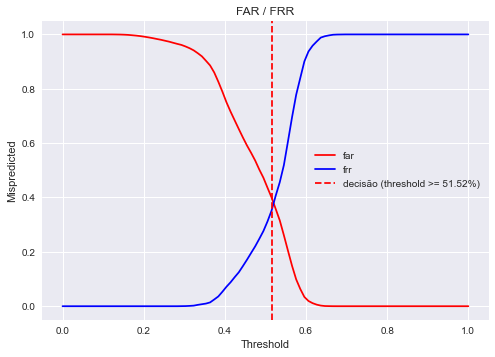

In [147]:
voting_threshold, y_pred_voting, voting_metricas = metricas_classificação('Voting', voting)
voting_metricas

## Stacking

In [148]:
stacking = StackingClassifier(estimators=[#('Baseline', dtc_baseline), 
                                      ('LogisticRegression', lr),
                                      ('RandomForest', rfc),
                                      #('SVC', svc),
                                   #   ('Bagging', bag),
                                      #('KNN', knn),
                                      #('GaussianNB', nb)
                                      ('AdaBoost', ada),
                               #       ('GradientBoosting', gbc)
                                      ('LGBM', lgbm)
                                      #('XGB', xgb)
], stack_method ='predict_proba') #, final_estimator=LGBMClassifier(objective='binary',random_state=42))

In [149]:
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('LogisticRegression',
                                LogisticRegression(C=0.004832930238571752,
                                                   class_weight='balanced',
                                                   random_state=42,
                                                   solver='liblinear')),
                               ('RandomForest',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=5,
                                                       max_features=0.4,
                                                       min_samples_leaf=2,
                                                       min_samples_split=7,
                                                       n_estimators=250,
                                                       oob_score=True,
                                                       random_state=42)),
                

Model: Stacking

Treino:

Confusion Matrix
[[11831  7254]
 [ 1570  2637]]


              precision    recall  f1-score   support

       False       0.88      0.62      0.73     19085
        True       0.27      0.63      0.37      4207

    accuracy                           0.62     23292
   macro avg       0.57      0.62      0.55     23292
weighted avg       0.77      0.62      0.66     23292



Teste:

Confusion Matrix
[[3860 2508]
 [ 581  815]]


              precision    recall  f1-score   support

       False       0.87      0.61      0.71      6368
        True       0.25      0.58      0.35      1396

    accuracy                           0.60      7764
   macro avg       0.56      0.59      0.53      7764
weighted avg       0.76      0.60      0.65      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Stacking Train,11831,7254,1570,2637,0.6212,0.2666,0.6268,0.3741,0.6234
Stacking,3860,2508,581,815,0.6021,0.2453,0.5838,0.3454,0.5950


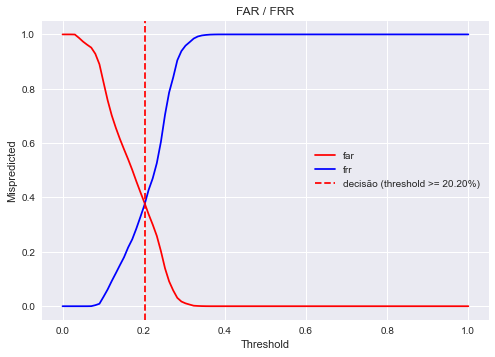

In [150]:
stacking_threshold, y_pred_stacking, stacking_metricas = metricas_classificação('Stacking', stacking)
stacking_metricas

### Results 

In [151]:
final_results = pd.concat([metrics, voting_metricas, stacking_metricas])

In [152]:
final_results

,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Baseline Train,19054,31,4,4203,0.9985,0.9927,0.9990,0.9959,0.9987
Baseline,5203,1165,1103,293,0.7079,0.2010,0.2099,0.2053,0.5135
LogisticRegression Train,11647,7438,1812,2395,0.6029,0.2436,0.5693,0.3412,0.5898
LogisticRegression,3874,2494,641,755,0.5962,0.2324,0.5408,0.3251,0.5746
RandomForest Train,11762,7323,1611,2596,0.6164,0.2617,0.6171,0.3675,0.6167
RandomForest,3849,2519,578,818,0.6011,0.2451,0.5860,0.3457,0.5952
SVC Train,0,19085,0,4207,0.1806,0.1806,1.0000,0.3060,0.5000
SVC,0,6368,0,1396,0.1798,0.1798,1.0000,0.3048,0.5000
KNN Train,13274,5811,0,4207,0.7505,0.4199,1.0000,0.5915,0.8478
KNN,3724,2644,738,658,0.5644,0.1993,0.4713,0.2801,0.5281


In [153]:
results_index = [indice for indice in final_results.index.tolist() if 'Train' not in indice]

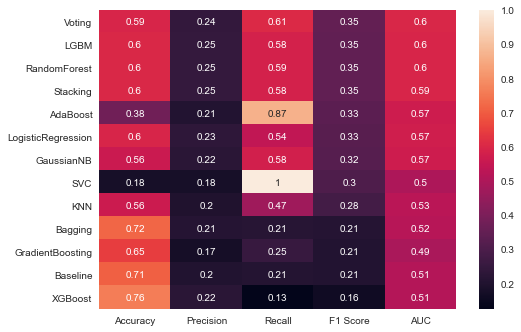

In [154]:
sns.heatmap(final_results.loc[results_index,
                              ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']].sort_values('F1 Score', 
                                                                                                  ascending=False),
            annot=True)
plt.show()

## 9. Feature Importance <a name="importance"></a>

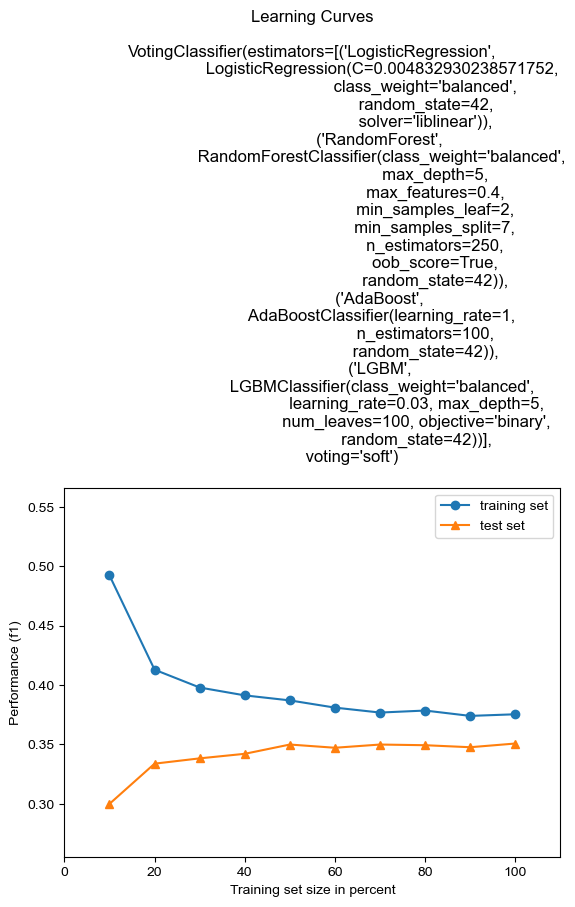

In [155]:
plot_learning_curves(X_train, y_train, X_test, y_test, voting, scoring='f1')
plt.show()

#### Permutation Importance

In [156]:
def feature_imp(modelo, X_test, y_test, n_repeats=10, random_state=0):
    result = permutation_importance(modelo, 
                                    X_test, y_test, 
                                    n_repeats=10,
                                    random_state=0)
    
    result_df = pd.DataFrame({'Features': X_test.columns, 'Importance': result.importances_mean})
    return result_df.set_index('Features').sort_values(by='Importance', ascending=False)

In [165]:
importance_voting = feature_imp(modelo=voting, 
            X_test=X_test,
            y_test=y_test, 
            n_repeats=10, 
            random_state=0)

In [166]:
importance_voting

,Importance
Features,
sum_units,0.013704
price_min,0.011154
count_orders_states_ne,0.010665
client_age,0.006157
price_25p,0.004598
count_category_lv1,0.004134
sum_negative,0.003220
price_std,0.002859
delivery_days_std,0.002370


Vamos investigar a performance de um modelo voting treinado com as 20 melhores features de acordo com a Permutation Importance.

In [169]:
voting2 = VotingClassifier(estimators=[#('Baseline', dtc_baseline), 
                                      ('LogisticRegression', lr),
                                      ('RandomForest', rfc),
                                      #('SVC', svc),
                                   #   ('Bagging', bag),
                                      #('KNN', knn),
                                      #('GaussianNB', nb)
                                      ('AdaBoost', ada),
                               #       ('GradientBoosting', gbc)
                                      ('LGBM', lgbm)
                                      #('XGB', xgb)
], voting ='soft')

In [187]:
voting2.fit(X_train[importance_voting.head(20).index.tolist()], y_train)

VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=0.004832930238571752,
                                                 class_weight='balanced',
                                                 random_state=42,
                                                 solver='liblinear')),
                             ('RandomForest',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     max_features=0.4,
                                                     min_samples_leaf=2,
                                                     min_samples_split=7,
                                                     n_estimators=250,
                                                     oob_score=True,
                                                     random_state=42)),
                             ('AdaBoost',
  

Model: Voting2

Treino:

Confusion Matrix
[[11574  7511]
 [ 1581  2626]]


              precision    recall  f1-score   support

       False       0.88      0.61      0.72     19085
        True       0.26      0.62      0.37      4207

    accuracy                           0.61     23292
   macro avg       0.57      0.62      0.54     23292
weighted avg       0.77      0.61      0.65     23292



Teste:

Confusion Matrix
[[3818 2550]
 [ 576  820]]


              precision    recall  f1-score   support

       False       0.87      0.60      0.71      6368
        True       0.24      0.59      0.34      1396

    accuracy                           0.60      7764
   macro avg       0.56      0.59      0.53      7764
weighted avg       0.76      0.60      0.64      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Voting2 Train,11574,7511,1581,2626,0.6097,0.2591,0.6242,0.3661,0.6153
Voting2,3818,2550,576,820,0.5974,0.2433,0.5874,0.3441,0.5935


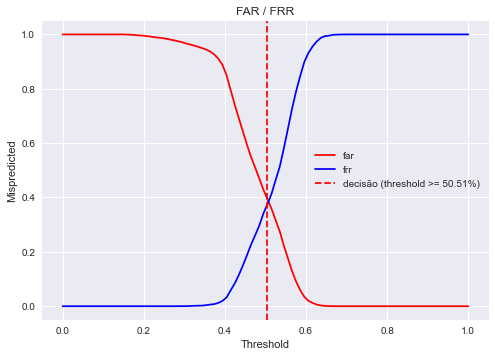

In [188]:
voting2_threshold, y_pred_voting2, voting2_metricas = metricas_classificação('Voting2', voting2, 
                                                                             X_tr=X_train[importance_voting.head(20).index.tolist()],
                                                                             X_te=X_test[importance_voting.head(20).index.tolist()])
voting2_metricas

#### SHAP

In [158]:
shap.initjs()

In [ ]:
explainer = shap.KernelExplainer(voting.predict,X_test)

In [ ]:
values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(values, X_test)

## 10. Conclusão <a name="conclusao"></a>

Por fim, o modelo de melhor performance será utilizado para fazer a previsão de Churn do desafio.

In [159]:
y_proba_challenge = voting.predict_proba(challenge_dataset)
y_pred_challenge = voting.predict(challenge_dataset)

In [160]:
y_pred_challenge = (y_proba_challenge[:,1] >= voting_threshold).astype(int)

In [161]:
resultado = pd.concat([challenge_dataset.reset_index(), 
                       pd.Series(y_pred_challenge)], axis=1)

In [162]:
resultado = resultado.rename(columns={0:'is_churn'})

In [163]:
resultado = resultado[['client_id', 'is_churn']].copy().set_index('client_id')

In [164]:
resultado.to_csv('resultado_ensembles.csv')